!pip install scikit-learn
!pip install umap-learn


In [2]:
from Bio import Entrez, SeqIO


In [3]:
Entrez.email = "osama2172003aldesoky.com"
query = "blaTEM AND Escherichia coli[Organism]"

retmax = 100
handle_search = Entrez.esearch(db="nucleotide", term=query, retmax=retmax)
search_results = Entrez.read(handle_search)
handle_search.close()
id_list = search_results["IdList"]
print(f" Number of retrieved sequences: {len(id_list)}")
handle_fetch = Entrez.efetch(db="nucleotide", id=id_list, rettype="fasta", retmode="text")
records = list(SeqIO.parse(handle_fetch, "fasta"))
handle_fetch.close()

print(f"Downloaded {len(records)} sequence from NCBI")
SeqIO.write(records, "tem1_sequences.fasta", "fasta")
print("The sequences were saved in a file: tem1_sequences.fasta")
print(search_results)


 Number of retrieved sequences: 100
Downloaded 93 sequence from NCBI
The sequences were saved in a file: tem1_sequences.fasta
{'Count': '26412', 'RetMax': '100', 'RetStart': '0', 'IdList': ['3024353050', '3023638427', '3023560251', '3023536798', '3022846721', '3022725241', '3022630913', '3022630876', '3020292345', '2752880018', '2524484095', '2255885729', '1148836538', '1119795159', '1119778745', '1103820147', '757605208', '692990478', '3015430272', '2752129683', '2521722531', '1888298469', '1862746456', '1853504665', '1816433663', '1816433658', '1816433652', '3012355828', '1883825494', '1866146194', '1836674118', '1816513184', '3010737428', '1848406648', '1800078768', '237640188', '1848406551', '1832836016', '410593098', '256367708', '1786223106', '2520284883', '2515153030', '1727822781', '1727822689', '1727822686', '1727822683', '1727822681', '1727822679', '1727822676', '1727822674', '1727822672', '1727822670', '1727822668', '1727822665', '1727822663', '1727822661', '1727822658', '17

In [4]:
from Bio import SeqIO
import pandas as pd

# Load sequences from a fasta file
records = list(SeqIO.parse("tem1_sequences.fasta", "fasta"))
print(f" Number of original sequences: {len(records)}")

min_len = 100
max_len = 3000

# Filter sequences by length
filtered = [r for r in records if min_len <= len(r.seq) <= max_len]
print(f" Number of filtered sequences: {len(filtered)}")

# Save them to a new file for analysis
SeqIO.write(filtered, "filtered_sequences.fasta", "fasta")

# Save sequence lengths to a table CSV (for later visualization)
lengths = [len(r.seq) for r in filtered]
pd.DataFrame({"length": lengths}).to_csv("sequence_lengths.csv", index=False)

print(" Filtered sequences and statistical data saved")

 Number of original sequences: 93
 Number of filtered sequences: 47
 Filtered sequences and statistical data saved


In [5]:
import subprocess
from Bio import AlignIO
import pandas as pd

#1) Input and Output Files
input_file = "filtered_sequences.fasta"
output_file = "aligned_sequences.aln"


clustal_path = r"D:\Osama\biotec\Bioinformatics\mutation_structural_analysis_ncbi\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\clustalo.exe"


#2) Run Alignment
cline = ClustalOmegaCommandline(
cmd=clustal_path,
infile=input_file,
outfile=output_file,
verbose=True,
auto=True,
force=True
)
print(" Running Alignment...")
cline()
print(" Alignment completed")

#3) Read alignment
alignment = AlignIO.read(output_file, "fasta")
L = alignment.get_alignment_length()
print(f" Alignment length: {L} column")

#4) Extract SNPs with list comprehension
snp_df = pd.DataFrame([
{
"Position": pos + 1,
"Variants": "".join(sorted(set(alignment[:, pos]) - {"-", "N"}))
}
for pos in range(L)
if len(set(alignment[:, pos]) - {"-", "N"}) > 1
])

#5) Save results
snp_df.to_csv("snp_table.csv", index=False)
print(f" {len(snp_df)} SNP mutation location identified")

D:\Osama\biotec\Bioinformatics\mutation_structural_analysis_ncbi\venv\Lib\site-packages\Bio\Application\__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


 Running Alignment...
 Alignment completed
 Alignment length: 2992 column
 2850 SNP mutation location identified


In [6]:
import numpy as np
from Bio import AlignIO

# 1) Read the alignment
alignment = AlignIO.read("aligned_sequences.aln", "fasta")
L = alignment.get_alignment_length()
n = len(alignment)

# 2) Calculate π for each column in one stroke
pi_values = []
for pos in range(L):
    column = alignment[:, pos]
    freqs = np.array([column.count(b) for b in set(column) if b not in ("-", "N")], float)
    total = freqs.sum()
    # Here we use ternary to avoid a lengthy if block
    pi_site = 0.0 if total < 2 else 1 - np.sum((freqs/total)**2)
    pi_values.append(pi_site)

# 3) π Total
pi_total = sum(pi_values) * 2 / (n * (n - 1))

#4) Print the result
print(f"📊 Number of sequences: {n}")
print(f"📊 Alignment length: {L}")
print(f"📊 Nucleotide diversity (π): {pi_total: .5f}")

📊 Number of sequences: 47
📊 Alignment length: 2992
📊 Nucleotide diversity (π):  1.57992


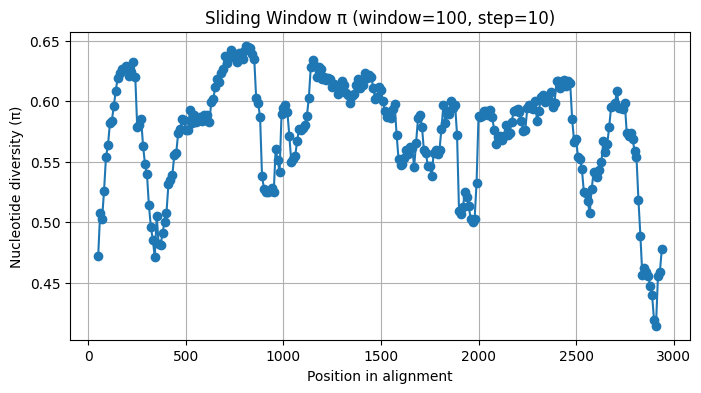

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from Bio import AlignIO

alignment = AlignIO.read("aligned_sequences.aln", "fasta")
L = alignment.get_alignment_length()
n = len(alignment)

def pi_site(column):
    freqs = np.array(
        [column.count(b) for b in set(column) if b not in ("-", "N")],
        dtype=float
    )
    total = freqs.sum()
    return 0.0 if total < 2 else 1 - np.sum((freqs/total)**2)

window_size = 100
step = 10
windows = range(0, L - window_size + 1, step)

pi_window = []
for start in windows:
    site_vals = [pi_site(alignment[:, pos]) for pos in range(start, start + window_size)]
    pi_window.append(np.mean(site_vals))

positions = [w + window_size/2 for w in windows]
plt.figure(figsize=(8, 4))
plt.plot(positions, pi_window, marker='o', linestyle='-')
plt.title("Sliding Window π (window=100, step=10)")
plt.xlabel("Position in alignment")
plt.ylabel("Nucleotide diversity (π)")
plt.grid(True)
plt.savefig("sliding_window_pi.png", dpi=300, bbox_inches='tight')
plt.show()


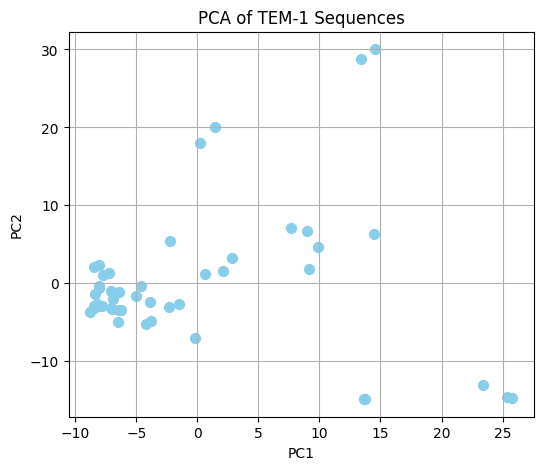

In [9]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

bases = ["A","T","G","C"]
n, L = len(alignment), alignment.get_alignment_length()
X = np.zeros((n, L * 4), dtype=int)
for i, record in enumerate(alignment):
    for j, b in enumerate(record.seq.upper()):
        if b in bases:
            X[i, 4*j + bases.index(b)] = 1

pca = PCA(n_components=2)
coords = pca.fit_transform(X)

plt.figure(figsize=(6, 5))
plt.scatter(coords[:, 0], coords[:, 1], c='skyblue', s=50)
plt.title("PCA of TEM-1 Sequences")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)

plt.savefig("pca_plot.png", dpi=300, bbox_inches='tight')
plt.show()


D:\Osama\biotec\Bioinformatics\mutation_structural_analysis_ncbi\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


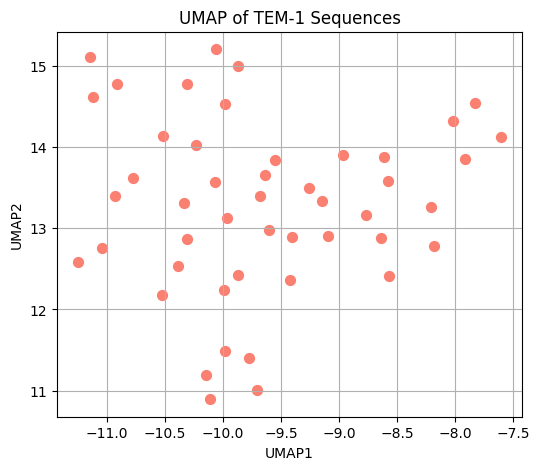

In [10]:
import umap

reducer = umap.UMAP(n_components=2, random_state=42)
umap_coords = reducer.fit_transform(X)

plt.figure(figsize=(6, 5))
plt.scatter(umap_coords[:, 0], umap_coords[:, 1], c='salmon', s=50)
plt.title("UMAP of TEM-1 Sequences")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.grid(True)

plt.savefig("umap_plot.png", dpi=300, bbox_inches='tight')
plt.show()


In [8]:
import numpy as np

pi_arr = np.array(pi_window)
high_thresh = np.percentile(pi_arr, 85)
low_thresh  = np.percentile(pi_arr, 15)

high_windows = [(positions[i], pi_arr[i])
                for i in range(len(pi_arr)) if pi_arr[i] >= high_thresh]
low_windows  = [(positions[i], pi_arr[i])
                for i in range(len(pi_arr)) if pi_arr[i] <= low_thresh]

print("High-diversity windows (pos, π):", high_windows)
print("Low-diversity windows (pos, π):",  low_windows)


High-diversity windows (pos, π): [(150.0, np.float64(0.6194133913237322)), (160.0, np.float64(0.6238210764893016)), (170.0, np.float64(0.6269075174772505)), (180.0, np.float64(0.6264379117308381)), (190.0, np.float64(0.6290302638596323)), (200.0, np.float64(0.6268832566688626)), (210.0, np.float64(0.6211521322937988)), (220.0, np.float64(0.6245821096472878)), (230.0, np.float64(0.632330266394394)), (240.0, np.float64(0.6202068988747873)), (660.0, np.float64(0.6185442120759767)), (680.0, np.float64(0.6232323801244771)), (690.0, np.float64(0.6266312744831919)), (700.0, np.float64(0.6376965494430101)), (710.0, np.float64(0.6319625927550881)), (720.0, np.float64(0.6376708147035726)), (730.0, np.float64(0.6427499240856092)), (740.0, np.float64(0.6369460678619772)), (750.0, np.float64(0.6378695972206083)), (760.0, np.float64(0.6325286551339384)), (770.0, np.float64(0.6397499468792047)), (780.0, np.float64(0.6389291897791651)), (790.0, np.float64(0.6354235601745633)), (800.0, np.float64(0.641

In [12]:
active_sites = [44, 66, 104, 166]  

aa_high = [int(pos/2) for pos, _ in high_windows]
aa_low  = [int(pos/2) for pos, _ in low_windows]

print("Overlap with active sites (high π):",
      set(aa_high) & set(active_sites))
print("Overlap with active sites (low π):",
      set(aa_low)  & set(active_sites))


Overlap with active sites (high π): set()
Overlap with active sites (low π): set()


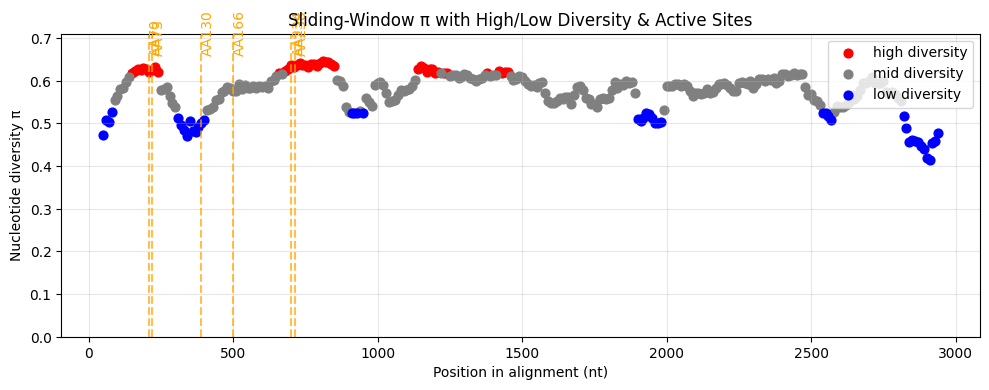

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from Bio import AlignIO

alignment   = AlignIO.read("aligned_sequences.aln", "fasta")
L           = alignment.get_alignment_length()
window_size = 100
step        = 10
windows     = np.arange(0, L-window_size+1, step)
pi_window   = [
    np.mean([
        0.0 if (lambda freqs: freqs.sum()<2)( 
            freqs := np.array(
                [alignment[:, pos].count(b) 
                 for b in set(alignment[:, pos]) 
                 if b not in ("-","N")],
                float
            )
        ) else 1 - np.sum((freqs/freqs.sum())**2)
        for pos in range(start, start+window_size)
    ])
    for start in windows
]

positions = windows + window_size/2

pi_arr     = np.array(pi_window)
high_thr   = np.percentile(pi_arr, 85)
low_thr    = np.percentile(pi_arr, 15)

groups = ["high" if val>=high_thr 
          else "low" if val<=low_thr 
          else "mid" 
          for val in pi_arr]

active_sites = [70, 73, 130, 166, 234, 238]

plt.figure(figsize=(10,4))
for grp, color in zip(["high","mid","low"], ["red","grey","blue"]):
    idx = [i for i,g in enumerate(groups) if g==grp]
    plt.scatter(positions[idx], pi_arr[idx], 
                c=color, label=f"{grp} diversity", s=40)

for aa in active_sites:
    nuc_pos = aa * 3
    plt.axvline(nuc_pos, color='orange', linestyle='--', alpha=0.7)
    plt.text(nuc_pos, max(pi_arr)*1.02, f"AA{aa}", 
             rotation=90, va='bottom', color='orange')

plt.title("Sliding-Window π with High/Low Diversity & Active Sites")
plt.xlabel("Position in alignment (nt)")
plt.ylabel("Nucleotide diversity π")
plt.legend(loc="upper right")
plt.ylim(0, max(pi_arr)*1.1)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("sliding_window_pi_annotated.png", dpi=300)
plt.show()


In [14]:
df = pd.DataFrame({
    "window_start": windows,
    "window_mid":    positions,
    "pi":            pi_arr,
    "group":         groups
})

df["aa_pos_mid"] = (df["window_mid"] / 3).round().astype(int)

df["overlaps_active"] = df["aa_pos_mid"].isin(active_sites)

df.to_csv("window_pi_functional_comparison.csv", index=False)

print("Windows that intersect with functional locations:")
print(df[df["overlaps_active"]])


Windows that intersect with functional locations:
    window_start  window_mid        pi group  aa_pos_mid  overlaps_active
16           160       210.0  0.621152  high          70             True
17           170       220.0  0.624582  high          73             True
34           340       390.0  0.500011   low         130             True


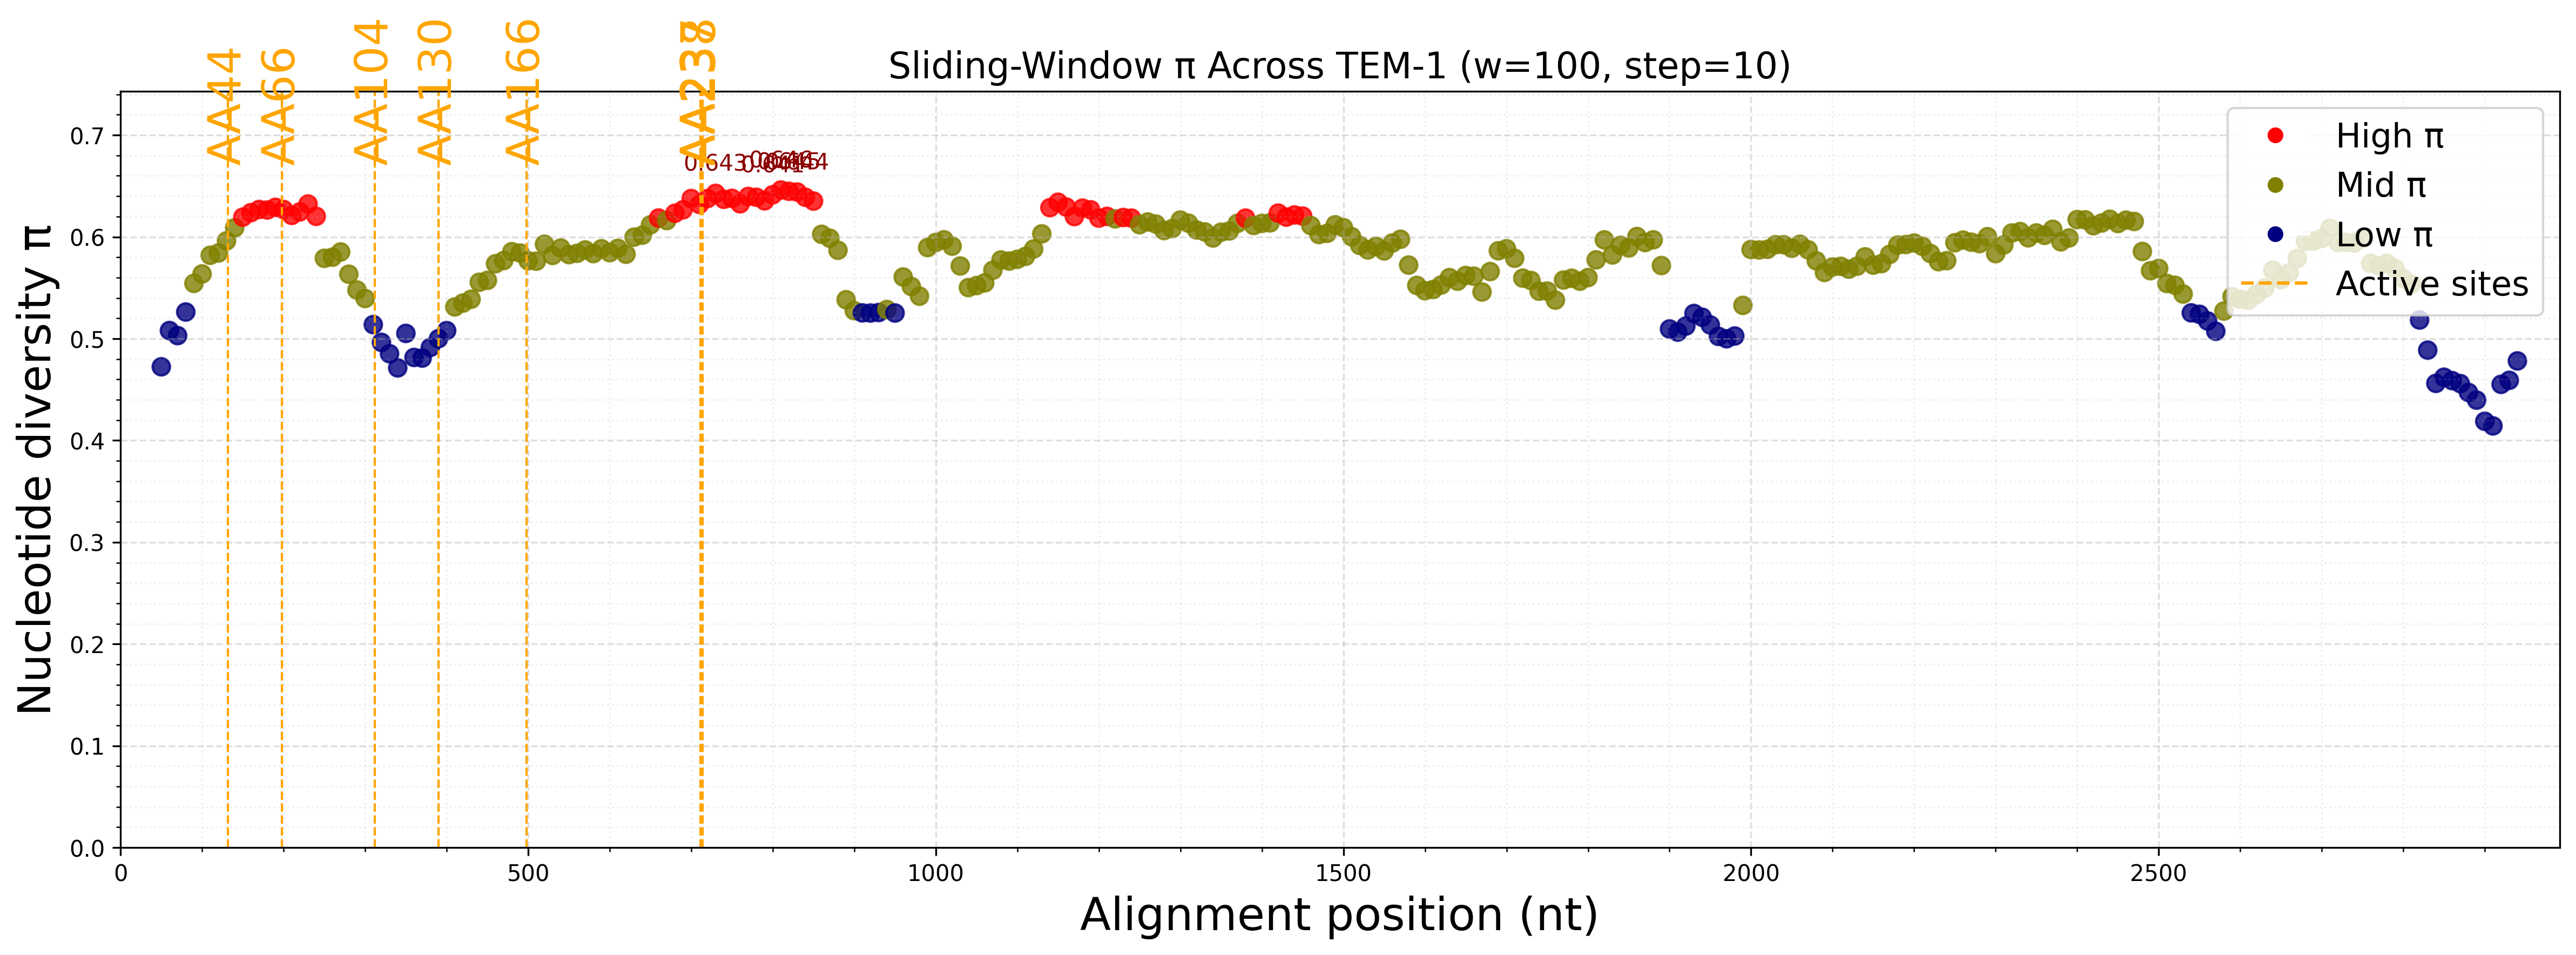

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from Bio import AlignIO

# 1) Load alignment
alignment   = AlignIO.read("aligned_sequences.aln", "fasta")
L           = alignment.get_alignment_length()
window_size = 100
step        = 10
starts      = np.arange(0, L - window_size + 1, step)

# 2) Compute sliding‐window π
def pi_window_vals(aln, starts, w):
    vals = []
    for s in starts:
        cols = [aln[:, i] for i in range(s, s + w)]
        pi_sites = []
        for col in cols:
            freqs = np.array(
                [col.count(b) for b in set(col) if b not in ("-", "N")],
                float
            )
            pi_sites.append(0.0 if freqs.sum() < 2 else 1 - np.sum((freqs/freqs.sum())**2))
        vals.append(np.mean(pi_sites))
    return np.array(vals)

pi_vals   = pi_window_vals(alignment, starts, window_size)
positions = starts + window_size/2

# 3) Categorize diversity levels
high_thr = np.percentile(pi_vals, 85)
low_thr  = np.percentile(pi_vals, 15)

colors = np.where(pi_vals >= high_thr, "red",
         np.where(pi_vals <= low_thr,  "navy", "olive"))

# 4) Active‐site mapping (AA positions)
active_sites_aa = [44, 66, 104, 130, 166, 237, 238]
active_sites_nt = [aa * 3 for aa in active_sites_aa]

# 5) Plotting
fig, ax = plt.subplots(figsize=(16, 6), dpi=300)
sc = ax.scatter(positions, pi_vals, c=colors, s=60, alpha=0.8)

# annotate top 5 peaks
top5 = np.argsort(pi_vals)[-5:]
for idx in top5:
    ax.annotate(f"{pi_vals[idx]:.3f}",
                (positions[idx], pi_vals[idx]),
                textcoords="offset points", xytext=(0, 10),
                ha="center", fontsize= 10, color="darkred")

# draw active‐site lines
for aa, nt in zip(active_sites_aa, active_sites_nt):
    ax.axvline(nt, color="orange", linestyle="--", linewidth=1)
    ax.text(nt, ax.get_ylim()[1]*1.02, f"AA{aa}",
            rotation=90, va="bottom", ha="center",
            fontsize=20, color="orange")

# formatting
ax.set_title("Sliding‐Window π Across TEM-1 (w=100, step=10)", fontsize=16)
ax.set_xlabel("Alignment position (nt)", fontsize=20)
ax.set_ylabel("Nucleotide diversity π", fontsize=20)
ax.set_xlim(0, L)
ax.set_ylim(0, pi_vals.max()*1.15)
ax.grid(which="major", linestyle="--", alpha=0.4)
ax.grid(which="minor", linestyle=":",  alpha=0.2)
ax.minorticks_on()

# custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='High π',   markerfacecolor='red',   markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Mid π',    markerfacecolor='olive',  markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Low π',    markerfacecolor='navy',  markersize=8),
    Line2D([0], [0], linestyle='--', color='orange', label='Active sites')
]
ax.legend(handles=legend_elements, loc="upper right", fontsize=15)

plt.tight_layout()
# save high-res image
fig.savefig("detailed_sliding_window_pi.png", dpi=300)
plt.show()


In [28]:
!pip install nglview biopython

In [29]:
!jupyter-nbextension enable nglview --py --sys-prefix

'jupyter-nbextension' is not recognized as an internal or external command,
operable program or batch file.


In [30]:
!jupyter labextension install nglview-js-widgets

(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
D:\Osama\biotec\Bioinformatics\mutation_structural_analysis_ncbi\venv\Lib\site-packages\jupyterlab\debuglog.py:54: UserWarning: An error occurred.
  warnings.warn("An error occurred.")
D:\Osama\biotec\Bioinformatics\mutation_structural_analysis_ncbi\venv\Lib\site-packages\jupyterlab\debuglog.py:55: UserWarning: ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
  warnings.warn(msg[-1].strip())
D:\Osama\biotec\Bioinformatics\mutation_structural_analysis_ncbi\venv\Lib\site-packages\jupyterlab\debuglog.py:56

In [31]:
%pip install nglview biopython ipywidgets


Note: you may need to restart the kernel to use updated packages.


In [1]:
import nglview as nv
print("nglview version:", nv.__version__)


nglview version: 3.1.4


D:\Osama\biotec\Bioinformatics\mutation_structural_analysis_ncbi\venv\Lib\site-packages\nglview\__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
from Bio.PDB import PDBList

pdbl = PDBList()
pdbl.retrieve_pdb_file("1ZG4", pdir=".", file_format="pdb")


'.\\pdb1zg4.ent'

In [15]:
from Bio.PDB import PDBList, PDBParser
import os

pdbl = PDBList()
pdb_path = pdbl.retrieve_pdb_file(
    "1ZG4",
    pdir=".",                    
    file_format="pdb"           
)
print("The file was downloaded to:", pdb_path)


base = os.path.basename(pdb_path)         # e.g. 'pdb1zg4.ent'
if base.startswith("pdb") and base.endswith(".ent"):
    new_name = "1zg4.pdb"
    os.rename(pdb_path, new_name)
    pdb_path = new_name
    print(" Renamed to:", pdb_path)

parser = PDBParser(QUIET=True)
structure = parser.get_structure("TEM1", pdb_path)
print(" The structure was successfully loaded from:", pdb_path)


import nglview as nv
view = nv.show_biopython(structure)
view.clear_representations()
view.add_cartoon(color="lightgrey")
view.add_ball_and_stick(selection="protein", color="grey")
view


Structure exists: '.\pdb1zg4.ent' 
The file was downloaded to: .\pdb1zg4.ent
 Renamed to: 1zg4.pdb
 The structure was successfully loaded from: 1zg4.pdb


NGLWidget()

In [34]:
critical_aas = [44, 66, 104, 130, 166, 237, 238]

for aa in critical_aas:
    view.add_ball_and_stick(
        selection=f"resi {aa} and protein",
        color="lightnavy",
        radius=1.8
    )


view.background = "black"             # أو "black"
view.parameters = {
    "clipNear": 0.1,
    "clipFar": 1000,
    "lightIntensity": 1.0
}

view.download_image(
    filename="mutations_on_structure.png",
    factor=3
)


In [35]:
import os
from IPython.display import Image, display
view


NGLWidget(background='black', n_components=1, picked={'atom1': {'index': 18, 'residueIndex': 2, 'resname': 'GL…

import os
import webbrowser

# 1) Parameters
pdb_id = "1zg4"
critical_residues = [44, 66, 104, 130, 166, 237, 238]
file_name = "mutations_viewer.html"

# 2) Build the HTML content
html = f"""<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <title>TEM-1 Mutational 3D Viewer</title>
  <script src="https://cdn.jsdelivr.net/npm/ngl@latest/dist/ngl.js"></script>
  <style>
    body {{ margin:0; background:#f5f5f5; font-family:sans-serif; }}
    #header {{ padding:15px; background:#222; color:#fff; }}
    #header h1 {{ margin:0; font-size:1.5em; }}
    #header p {{ margin:5px 0 0; font-size:1em; }}
    #viewport {{ width:100%; height:90vh; }}
  </style>
</head>
<body>
  <div id="header">
    <h1>TEM-1 β-lactamase Mutational Mapping</h1>
    <p>Critical residues highlighted: {', '.join(map(str, critical_residues))}</p>
  </div>
  <div id="viewport"></div>
  <script>
    // create the NGL Stage object
    var stage = new NGL.Stage("viewport");

    // load PDB directly from RCSB
    stage.loadFile("rcsb://{pdb_id}").then(function(o) {{
      // cartoon representation of the entire protein
      o.addRepresentation("cartoon", {{ color: "lightgrey" }});
      // highlight critical residues
      o.addRepresentation("ball+stick", {{
        sele: "{' or '.join(str(r) for r in critical_residues)}",
        color: "crimson",
        radius: 1.5
      }});
      stage.autoView();
    }});
  </script>
</body>
</html>
"""

# 3) Write the HTML to disk
with open(file_name, "w", encoding="utf-8") as f:
    f.write(html)
print(f"✅ Written interactive viewer to {file_name}")

# 4) Open the file in the default web browser (usually Chrome)
path = os.path.abspath(file_name)
webbrowser.open_new_tab(f"file:///{path}")


In [33]:
view.clear_representations()

view.add_cartoon(color="lightgrey")            # cartoon
view.add_ball_and_stick(color="lightnavy", sele="resi 44-50")   
view.add_ribbon(color="navy")                 # ribbon
view.add_licorice(color="green")                # licorice
view.add_line(color="gray")                     # line
view.add_point(color="black")                   # point

view.parameters = {"clipNear":0.5, "clipFar":300}
view


NGLWidget(n_components=1, picked={'atom1': {'index': 18, 'residueIndex': 2, 'resname': 'GLU', 'x': 6.738999843…

In [31]:
import os, webbrowser

# 1) PARAMETERS
pdb_id = "1zg4"
critical_residues = [44, 66, 104, 130, 166, 237, 238]
html_file = "mutations_structure.html"

# 2) BUILD THE HTML
html = f"""<!DOCTYPE html>
<html>
<head>
  <meta charset="utf-8">
  <title>TEM-1 β-lactamase 3D Viewer</title>
  <script src="https://cdn.jsdelivr.net/npm/ngl@latest/dist/ngl.js"></script>
  <style>
    body {{ margin:0; font-family:sans-serif; background:#f0f0f0 }}
    #header {{ padding:12px; background:#333; color:#fff }}
    #header h1 {{ margin:0; font-size:1.4em }}
    #header p {{ margin:4px 0 0; font-size:.95em }}
    #viewport {{ width:100vw; height:calc(100vh - 60px) }}
  </style>
</head>
<body>
  <div id="header">
    <h1>TEM-1 Mutational Mapping</h1>
    <p>Highlighted residues: {', '.join(map(str, critical_residues))}</p>
  </div>
  <div id="viewport"></div>
  <script>
    const stage = new NGL.Stage("viewport");
    stage.loadFile("rcsb://{pdb_id}").then(o => {{
      o.addRepresentation("cartoon", {{ color: "lightgrey" }});
      o.addRepresentation("surface", {{color:"lightblue", opacity:0.3}});
      o.addRepresentation("ball+stick", {{
        sele: "{' or '.join(':'+str(r) for r in critical_residues)}",
        color: "crimson",
        radius: 1.4
      }});
      stage.autoView();
    }});
  </script>
</body>
</html>
"""

# 3) WRITE TO DISK
with open(html_file, "w", encoding="utf-8") as f:
    f.write(html)
print("✅ Written standalone HTML to", html_file)

# 4) OPEN IN BROWSER
path = os.path.abspath(html_file)
webbrowser.open(f"file:///{path}")


✅ Written standalone HTML to mutations_structure.html


True

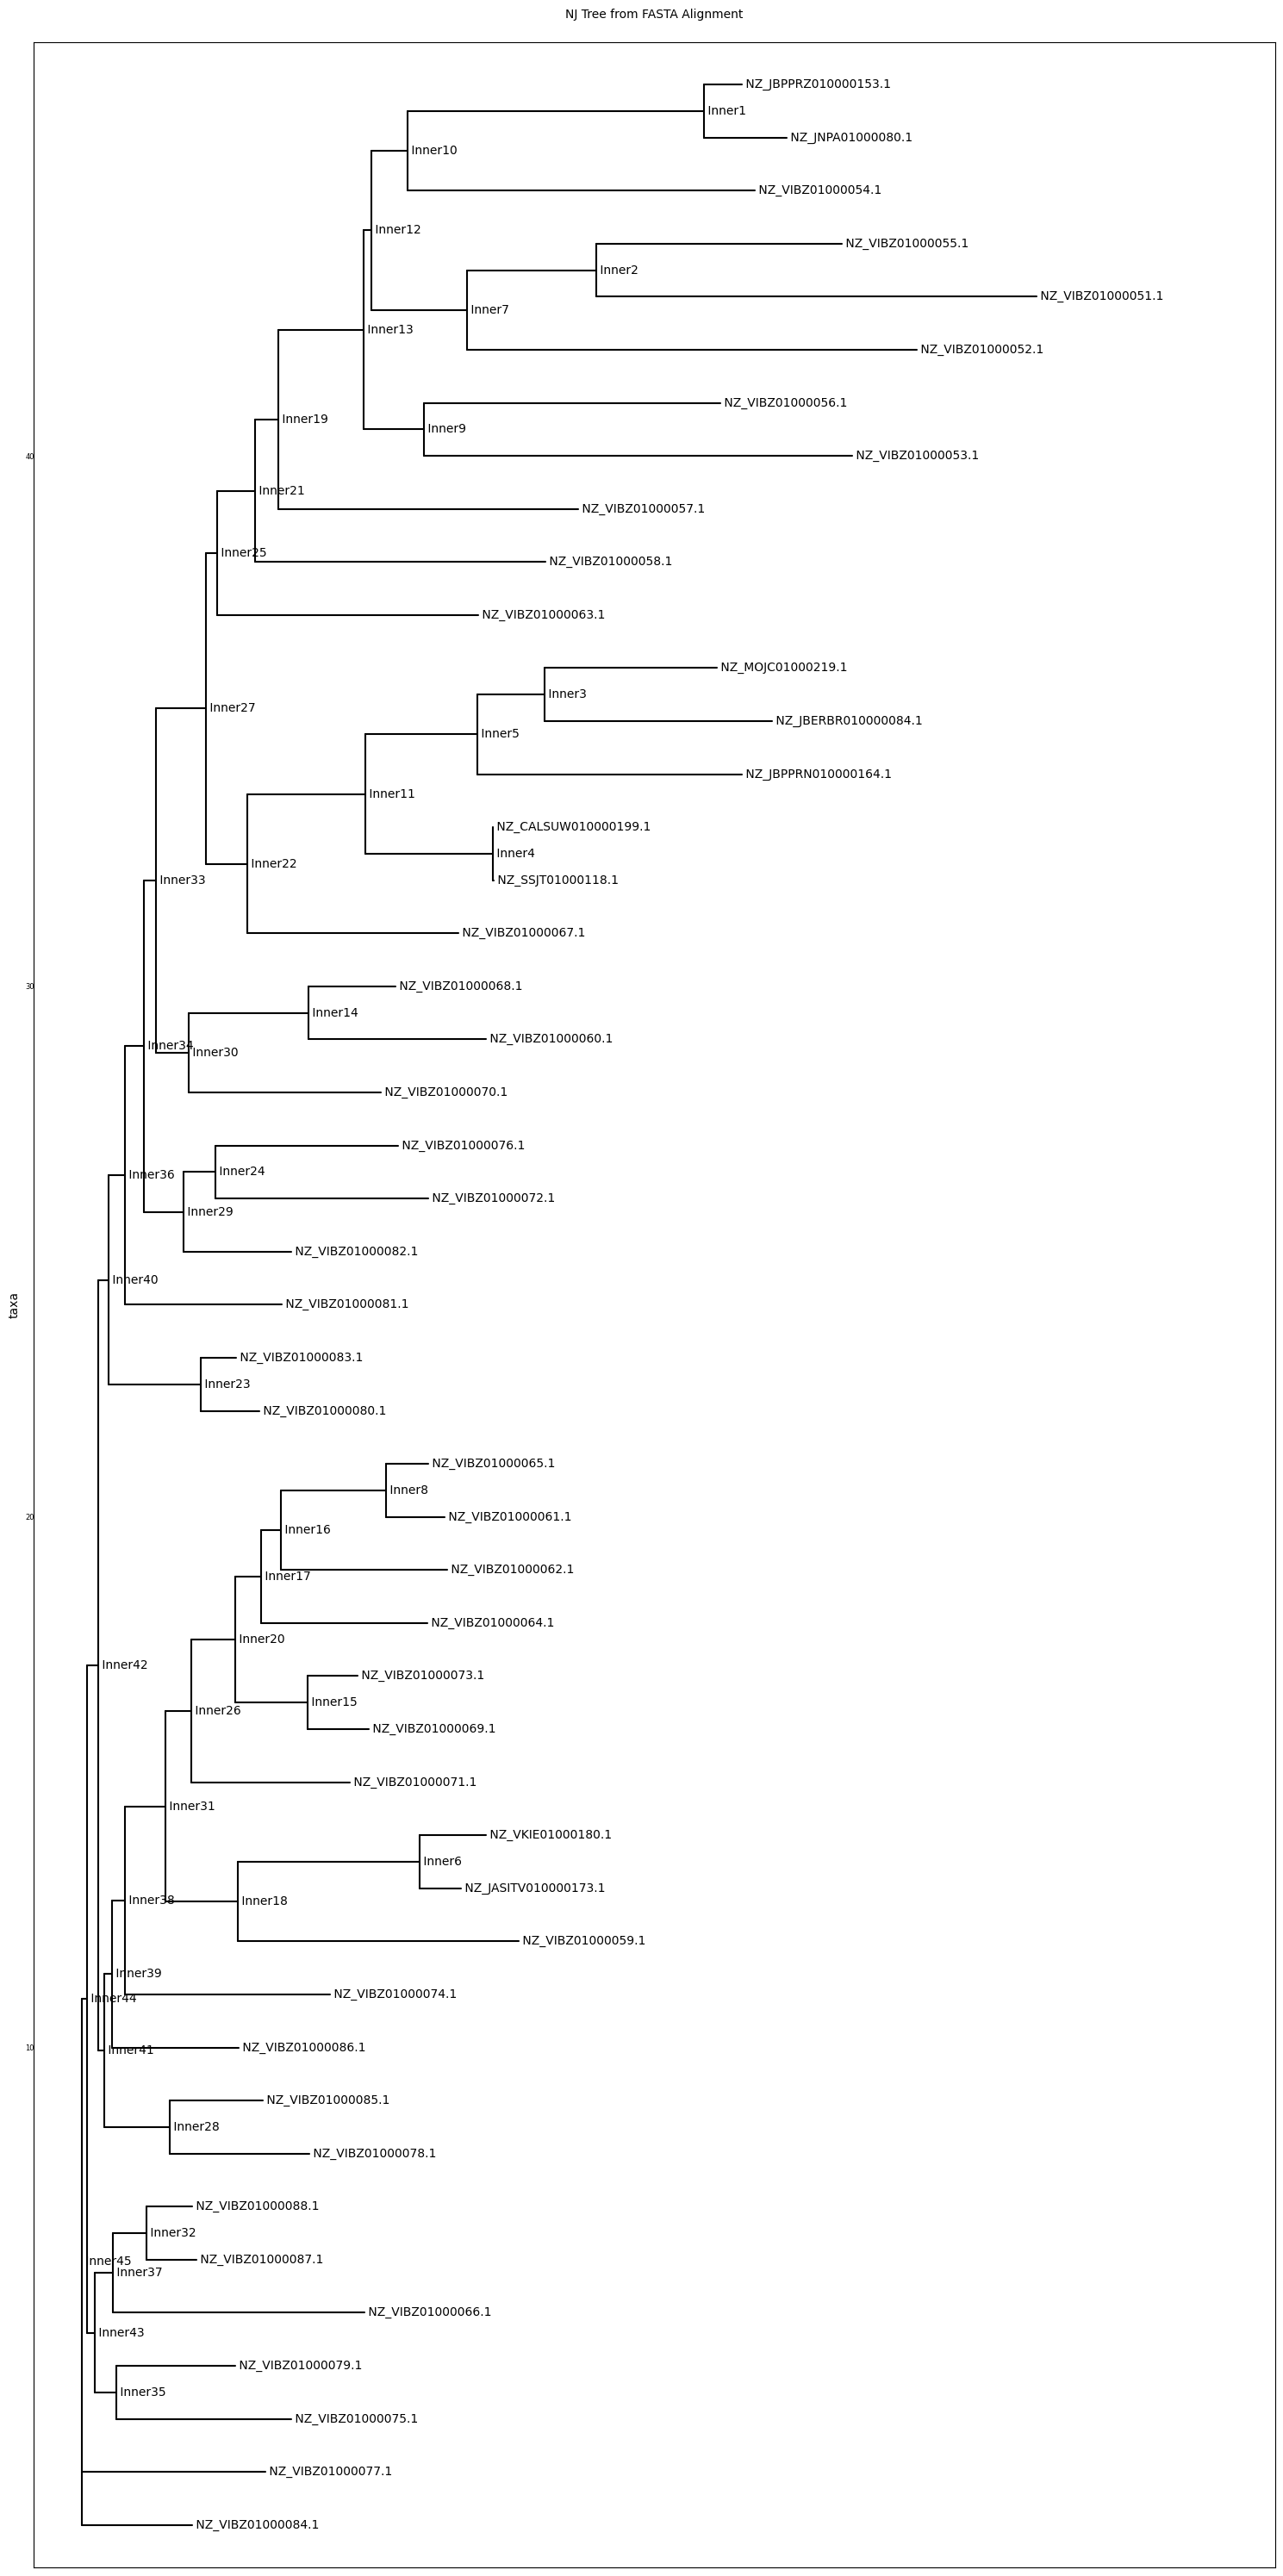

In [47]:
from Bio import AlignIO, Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
import matplotlib.pyplot as plt
import os

alignment_file = "aligned_sequences.aln"  
if not os.path.exists(alignment_file):
    raise FileNotFoundError(f"{alignment_file} not found in {os.getcwd()}")

alignment = AlignIO.read(alignment_file, "fasta")
calc      = DistanceCalculator("identity")
dm        = calc.get_distance(alignment)
nj_cons   = DistanceTreeConstructor()
tree      = nj_cons.nj(dm)

tree.ladderize()

fig = plt.figure(figsize=(15, 30))              
ax  = fig.add_subplot(1, 1, 1)

Phylo.draw(tree,
           axes=ax,
           do_show=False,
           show_confidence=False)


for lbl in ax.get_yticklabels():
    lbl.set_fontsize(6)
    lbl.set_horizontalalignment('left')       

ax.set_ylim(ax.get_ylim()[::-1])             
ax.xaxis.set_visible(False)                  
ax.tick_params(left=False)                    
plt.title("NJ Tree from FASTA Alignment", fontsize=10, pad=20)
plt.tight_layout()

plt.savefig("NJ_tree.png",
            dpi=300,            
            bbox_inches="tight" 
           )

plt.show()





In [38]:
import os

print("Current working directory:", os.getcwd())
print("Files in cwd:", os.listdir())


Current working directory: D:\Osama\biotec\Bioinformatics\mutation_structural_analysis_ncbi
Files in cwd: ['.ipynb_checkpoints', '1zg4.pdb', 'aligned_sequences.aln', 'clustal-omega-1.2.2-win64', 'detailed_sliding_window_pi.png', 'diversity_windows.csv', 'filtered_sequences.fasta', 'from Bio import Entrez, SeqIO.py', 'mutations3d.html', 'mutations3d.txt', 'mutations_on_structure (1).png', 'mutations_on_structure (2).png', 'mutations_on_structure.png', 'mutations_structure.html', 'mutations_viewer.html', 'pca_plot.png', 'pdb1zg4.ent', 'sequence_lengths.csv', 'sliding_window_pi.png', 'sliding_window_pi_annotated.png', 'snp_table.csv', 'tem.pdf', 'tem1_sequences.fasta', 'TEM_analysis.html', 'TEM_analysis.ipynb', 'TEM_analysis.ipynb2', 'umap_plot.png', 'venv', 'window_pi_functional_comparison.csv']


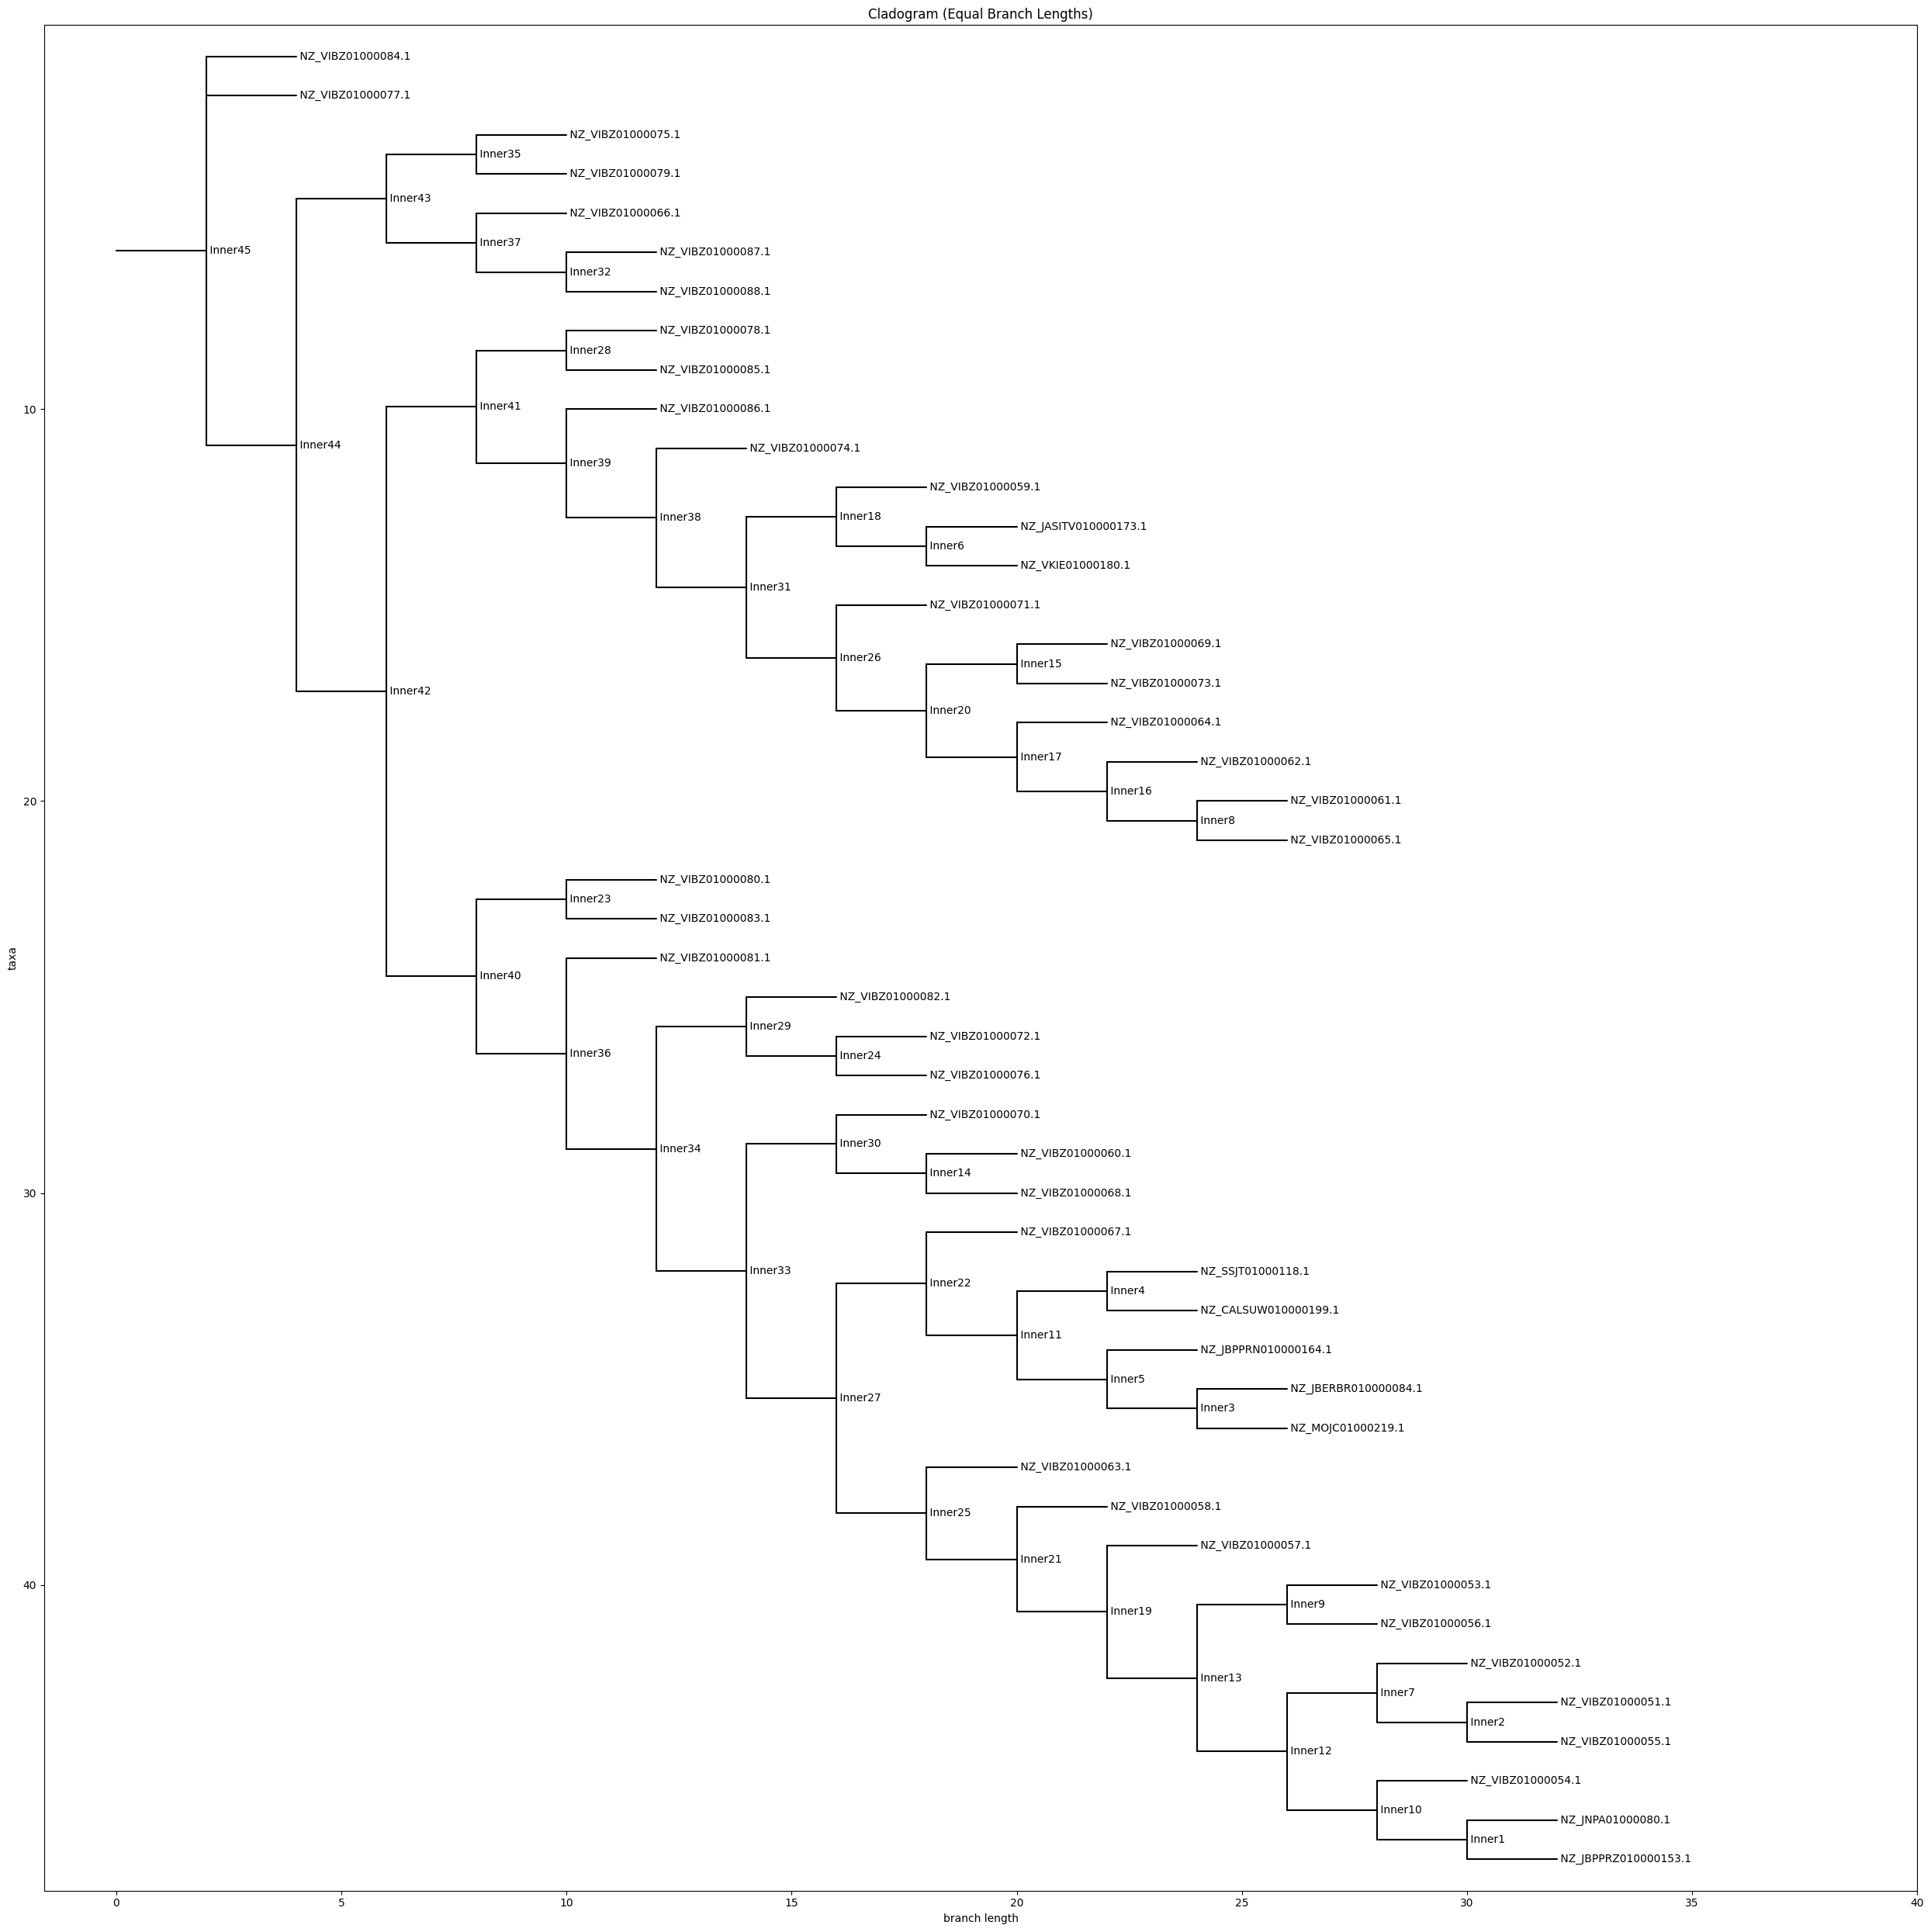

In [52]:
for clade in tree.find_clades():
    clade.branch_length = 2.0

# رسم
fig = plt.figure(figsize=(25, 25))
ax  = fig.add_subplot(1, 1, 1)

Phylo.draw(tree, axes=ax, do_show=False, show_confidence=False)
plt.title("Cladogram (Equal Branch Lengths)")
plt.tight_layout()
plt.savefig("tree_cladogram.png", dpi=300, bbox_inches="tight")
plt.show()


In [65]:
!pip install requests

In [66]:
from Bio.KEGG import REST
import pandas as pd

print("Searching KEGG for 'blaTEM' related entries...")
result = REST.kegg_find("genes", "blaTEM").read()

kegg_entries = []
if result:
    for line in result.strip().split('\n'):
        parts = line.split('\t')
        if len(parts) > 1:
            kegg_id = parts[0]
            description = parts[1]
            kegg_entries.append({'KEGG ID': kegg_id, 'Description': description})
else:
    print("No KEGG entries found for 'blaTEM'.")

if kegg_entries:
    df_kegg_entries = pd.DataFrame(kegg_entries)
    print("\nFound KEGG entries:")
    print(df_kegg_entries.to_string())


    if not df_kegg_entries.empty:
        first_kegg_id = df_kegg_entries['KEGG ID'].iloc[0]
        print(f"\nRetrieving pathways for KEGG ID: {first_kegg_id}...")
        pathway_results = REST.kegg_link("pathway", first_kegg_id).read()

        kegg_pathways = []
        if pathway_results:
            for line in pathway_results.strip().split('\n'):
                parts = line.split('\t')
                if len(parts) > 1:
                    path_id = parts[1]
                    path_info = REST.kegg_get(path_id).read()
                    path_name = "N/A"
                    for p_line in path_info.split('\n'):
                        if p_line.startswith("NAME"):
                            path_name = p_line.split("  ")[1].strip()
                            break
                    kegg_pathways.append({'Pathway ID': path_id, 'Pathway Name': path_name})
            df_kegg_pathways = pd.DataFrame(kegg_pathways)
            print("\nAssociated KEGG Pathways:")
            print(df_kegg_pathways.to_string())
        else:
            print(f"No pathways found for {first_kegg_id}.")
else:
    print("No KEGG entries to retrieve pathways for.")

Searching KEGG for 'blaTEM' related entries...

Found KEGG entries:
            KEGG ID                                          Description
0  ecos:EC958_A0053                                      blaTEM-1; TEM-1
1   cfq:C2U38_26795  blaTEM; class A broad-spectrum beta-lactamase TEM-1
2   cir:C2U53_00280  blaTEM; class A broad-spectrum beta-lactamase TEM-1
3   cie:AN232_27700  blaTEM; class A broad-spectrum beta-lactamase TEM-1
4   cie:AN232_30620  blaTEM; class A broad-spectrum beta-lactamase TEM-1
5   ebc:C2U52_00385  blaTEM; class A broad-spectrum beta-lactamase TEM-1
6    abn:AB57_06335                                        blaTEM; TEM-1
7   nsi:A6J88_09500  blaTEM; class A broad-spectrum beta-lactamase TEM-1
8     bww:bwei_5861            blaTEM-116; ampicillin resistance protein

Retrieving pathways for KEGG ID: ecos:EC958_A0053...

Associated KEGG Pathways:
       Pathway ID Pathway Name
0  path:ecos01501             


In [67]:
if not df_kegg_pathways.empty:
    example_path_id = df_kegg_pathways['Pathway ID'].iloc[0] 
    print(f"\nGetting details for pathway: {example_path_id}")
    pathway_details = REST.kegg_get(example_path_id).read()
    print(pathway_details)


Getting details for pathway: path:ecos01501
ENTRY       ecos01501                   Pathway
NAME        beta-Lactam resistance - Escherichia coli O25b:K100:H4-ST131 EC958 (UPEC)
DESCRIPTION The beta-lactam antibiotics are the most widely used group of antibiotics, which exert their effect by interfering with the structural crosslinking of peptidoglycans in bacterial cell walls. Over the past decades, a rapid increase in the number of beta-lactam-resistant clinical isolates is observed. Bacterial resistance to beta-lactam antibiotics can be achieved by any of the following strategies: producing inactivating enzymes called beta-lactamases, altering the beta-lactam targets of penicillin-binding proteins (PBPs), reducing transport of beta-lactams into the periplasmic space via changes in porins, and using the mechanisms for exclusion of beta-lactams by way of efflux pumps. Resistance may result from intrinsic properties of organisms, through gene mutations, and through plasmid- and transp

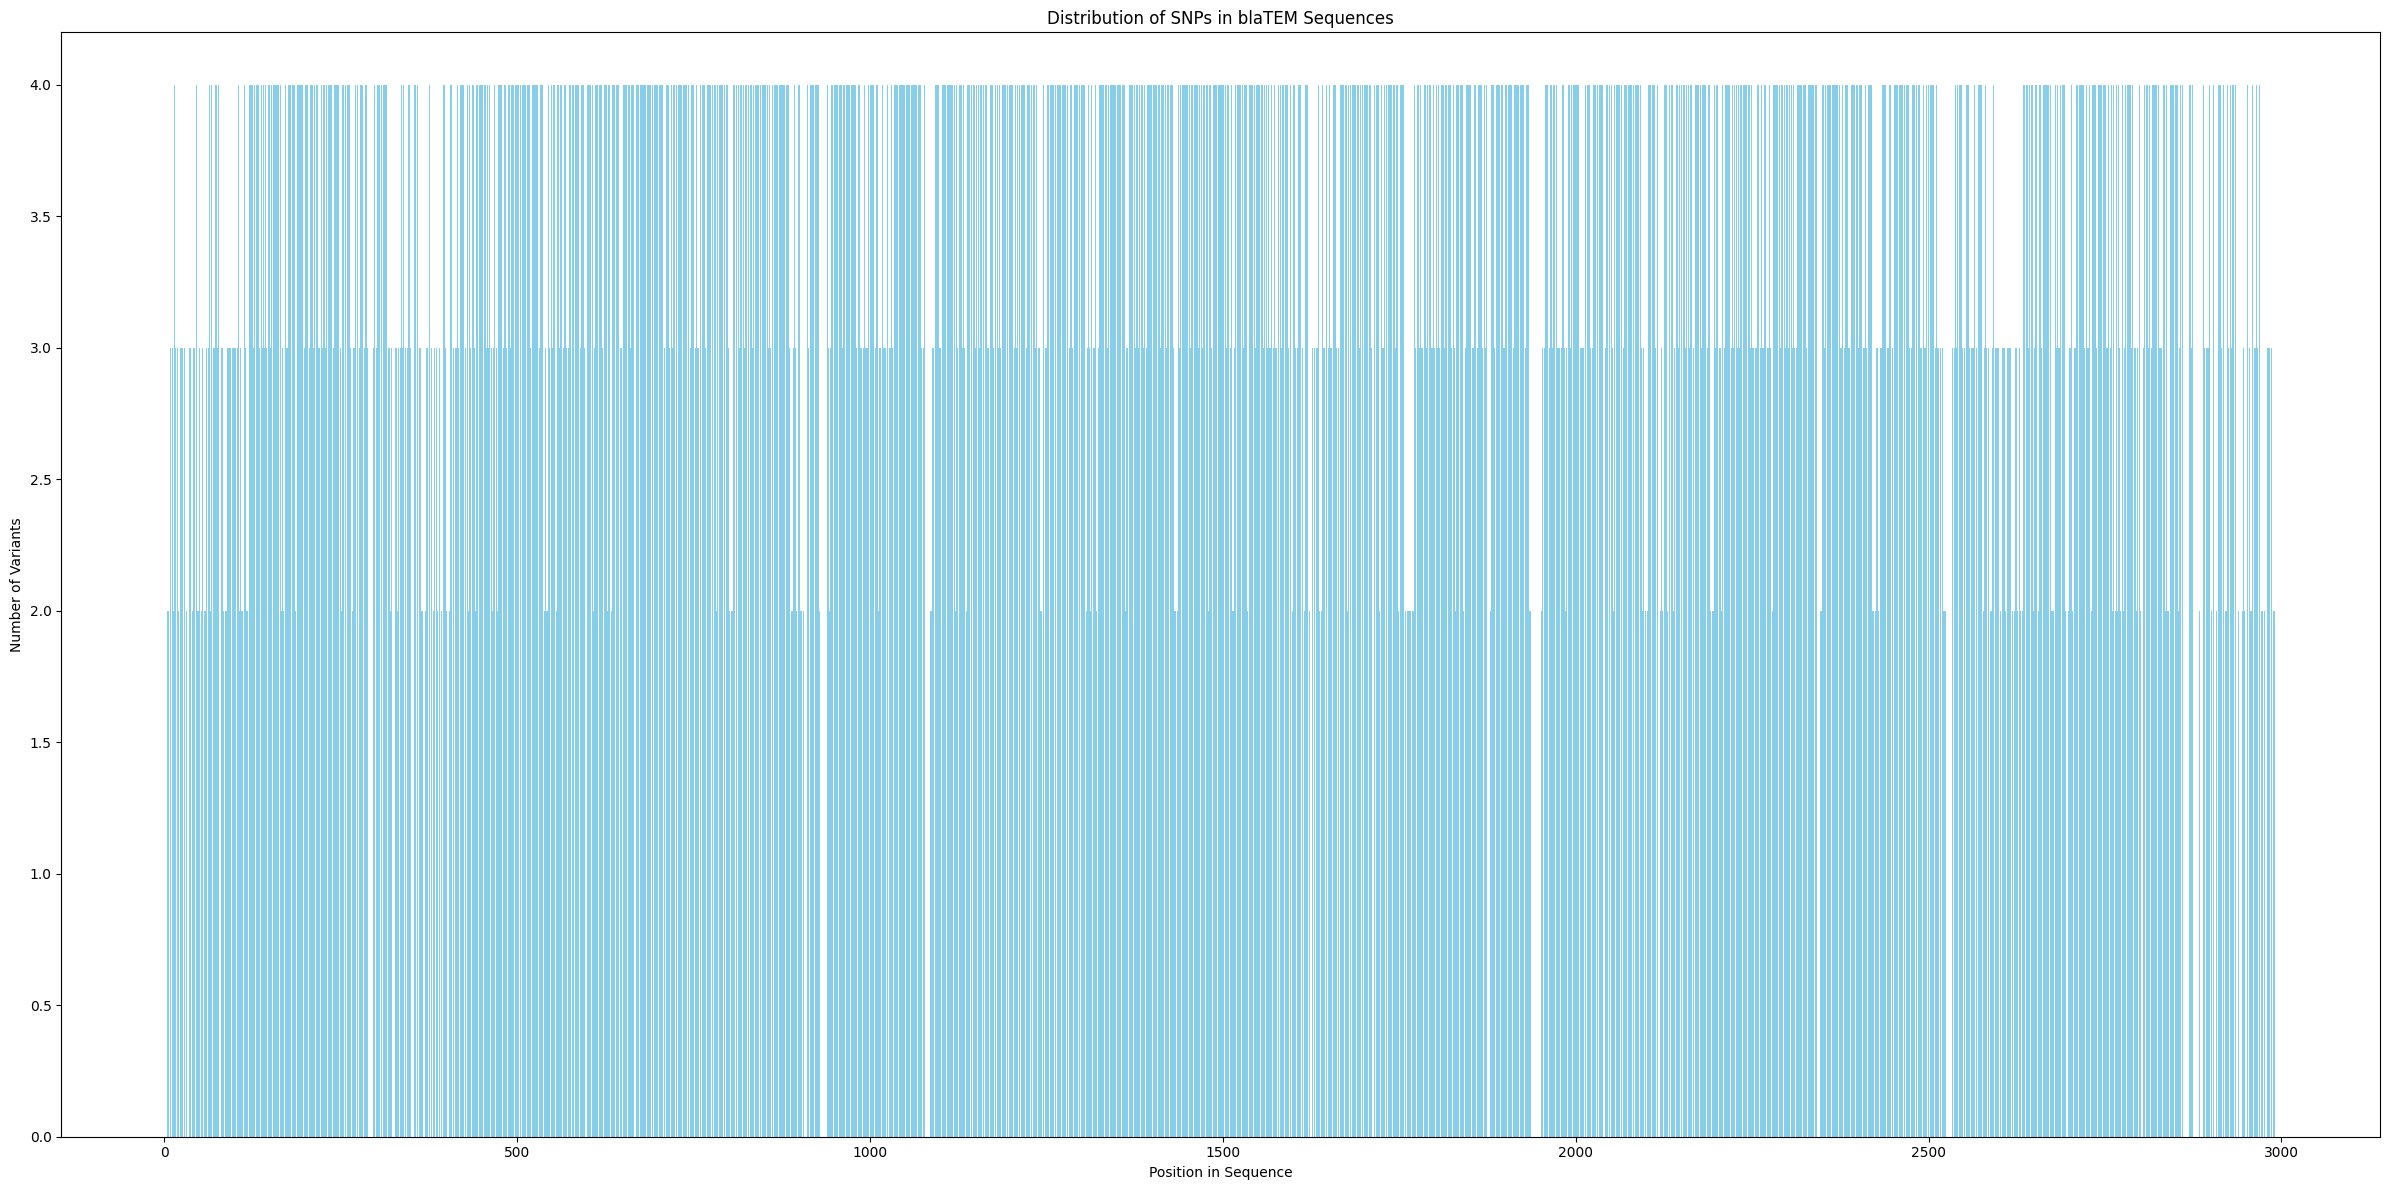

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

snp_df = pd.read_csv("snp_table.csv")

plt.figure(figsize=(24, 12))
plt.bar(snp_df["Position"], snp_df["Variants"].str.len(), color="skyblue")
plt.xlabel("Position in Sequence")
plt.ylabel("Number of Variants")
plt.title("Distribution of SNPs in blaTEM Sequences")
plt.tight_layout()
plt.savefig("snp_distribution.png", dpi=300)
plt.show()

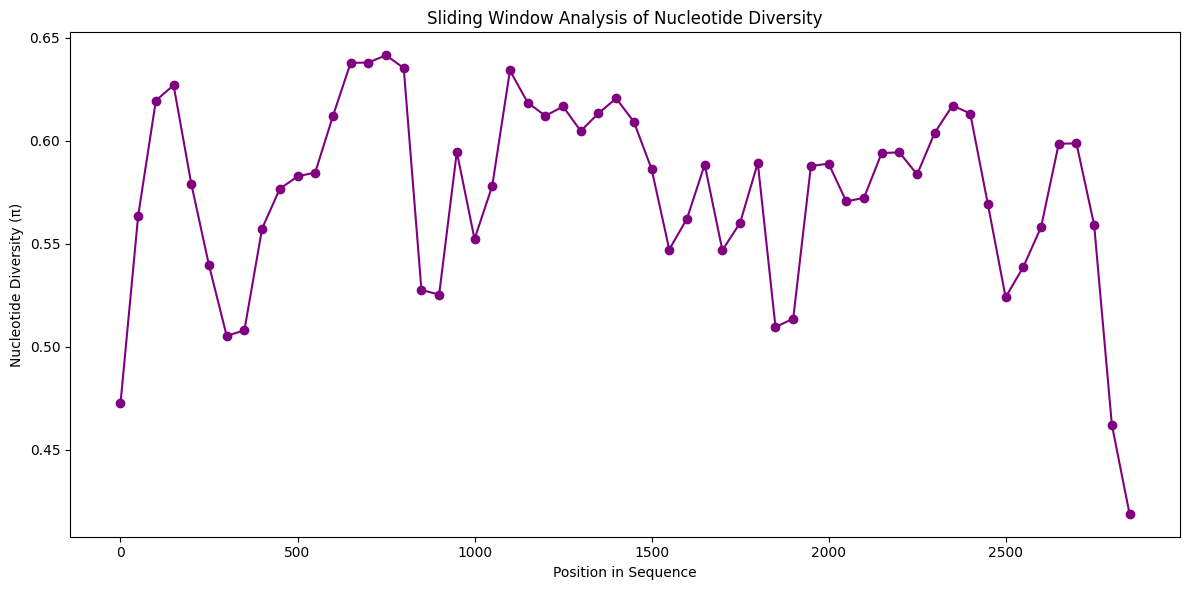

In [75]:
import numpy as np
from Bio import AlignIO
import matplotlib.pyplot as plt

alignment = AlignIO.read("aligned_sequences.aln", "fasta")

window_size = 100
step_size = 50
pi_values = []

for start in range(0, alignment.get_alignment_length() - window_size + 1, step_size):
    window = alignment[:, start:start + window_size]
    pi = 0.0 
    
    for pos in range(window_size):
        column = window[:, pos]  
        freqs = [column.count(b) for b in set(column) if b not in ("-", "N")]
        total = sum(freqs)
        if total > 1:  
            pi_site = 1 - sum((f / total) ** 2 for f in freqs)
            pi += pi_site
    
    pi = pi / window_size if window_size > 0 else 0
    pi_values.append(pi)

positions = range(0, len(pi_values) * step_size, step_size)

plt.figure(figsize=(12, 6))
plt.plot(positions, pi_values, "-o", color="purple")
plt.xlabel("Position in Sequence")
plt.ylabel("Nucleotide Diversity (π)")
plt.title("Sliding Window Analysis of Nucleotide Diversity")
plt.tight_layout()
plt.savefig("nucleotide_diversity_sliding.png", dpi=300)
plt.show()

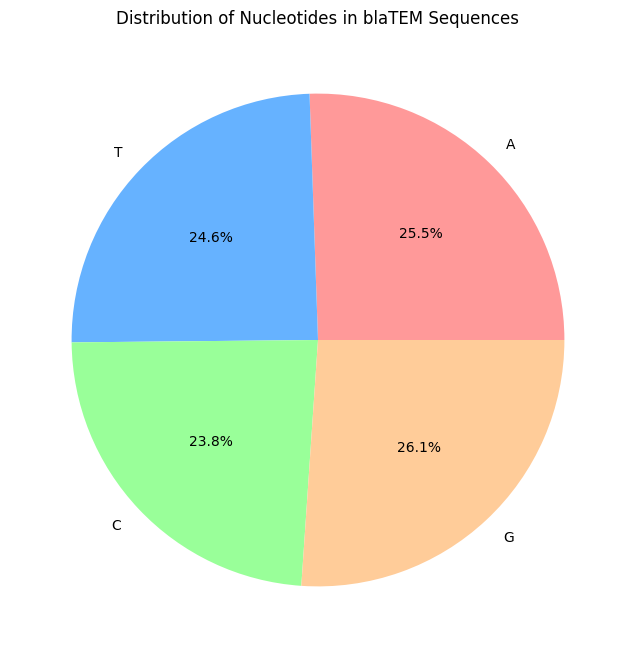

In [77]:
from Bio import AlignIO
import matplotlib.pyplot as plt

alignment = AlignIO.read("aligned_sequences.aln", "fasta")

nucleotide_counts = {'A': 0, 'T': 0, 'C': 0, 'G': 0}
for record in alignment:
    for base in record.seq:
        if base in nucleotide_counts:
            nucleotide_counts[base] += 1

total = sum(nucleotide_counts.values())
nucleotide_percentages = {k: v / total * 100 for k, v in nucleotide_counts.items()}

plt.figure(figsize=(8, 8))
plt.pie(nucleotide_percentages.values(), labels=nucleotide_percentages.keys(), autopct='%1.1f%%', colors=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'])
plt.title("Distribution of Nucleotides in blaTEM Sequences")
plt.savefig("nucleotide_distribution_pie.png", dpi=300)
plt.show()

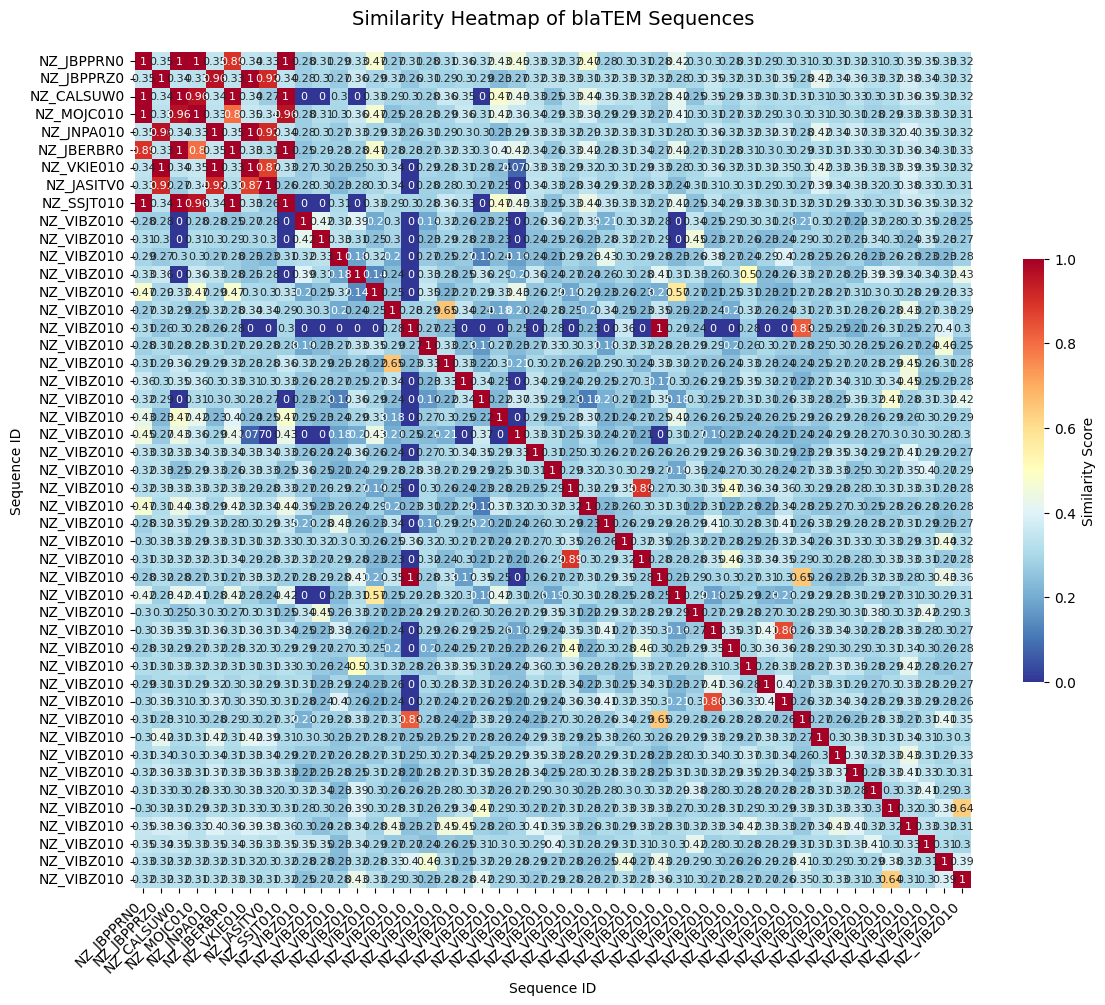

In [82]:
from Bio import AlignIO
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

alignment = AlignIO.read("aligned_sequences.aln", "fasta")

n_seqs = len(alignment)
similarity_matrix = np.zeros((n_seqs, n_seqs))
for i in range(n_seqs):
    for j in range(n_seqs):
        matches = sum(a == b and a != '-' for a, b in zip(alignment[i].seq, alignment[j].seq))
        total = sum(1 for a, b in zip(alignment[i].seq, alignment[j].seq) if a != '-' and b != '-')
        similarity_matrix[i, j] = matches / total if total > 0 else 0

labels = [rec.id[:10] if len(rec.id) > 10 else rec.id for rec in alignment]  

plt.figure(figsize=(12, 10))  
sns.heatmap(similarity_matrix, 
            annot=True,             
            cmap="RdYlBu_r",         
            vmin=0, vmax=1,          
            xticklabels=labels,      
            yticklabels=labels,      
            annot_kws={"size": 8},  
            square=True,            
            cbar_kws={"shrink": 0.5, "label": "Similarity Score"})  

plt.xticks(rotation=45, ha="right")  
plt.yticks(rotation=0)                
plt.title("Similarity Heatmap of blaTEM Sequences", pad=20, size=14)
plt.xlabel("Sequence ID")
plt.ylabel("Sequence ID")

plt.tight_layout()
plt.savefig("similarity_heatmap_improved.png", dpi=300, bbox_inches="tight")
plt.show()

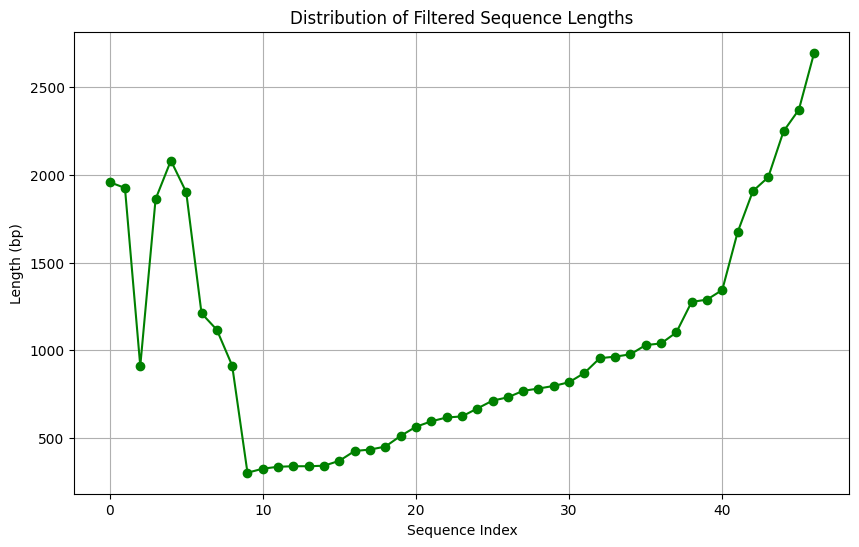

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

lengths_df = pd.read_csv("sequence_lengths.csv")

plt.figure(figsize=(10, 6))
plt.plot(lengths_df.index, lengths_df["length"], "-o", color="green")
plt.xlabel("Sequence Index")
plt.ylabel("Length (bp)")
plt.title("Distribution of Filtered Sequence Lengths")
plt.grid(True)
plt.savefig("sequence_length_distribution.png", dpi=300)
plt.show()

In [80]:
from Bio import SeqIO
import pandas as pd

original_records = list(SeqIO.parse("tem1_sequences.fasta", "fasta"))
filtered_records = list(SeqIO.parse("filtered_sequences.fasta", "fasta"))

original_lengths = [len(r.seq) for r in original_records]
filtered_lengths = [len(r.seq) for r in filtered_records]

stats = {
    "Dataset": ["Original", "Filtered"],
    "Number of Sequences": [len(original_records), len(filtered_records)],
    "Mean Length": [round(sum(original_lengths) / len(original_lengths), 2), round(sum(filtered_lengths) / len(filtered_lengths), 2)],
    "Standard Deviation": [round(pd.Series(original_lengths).std(), 2), round(pd.Series(filtered_lengths).std(), 2)]
}

stats_df = pd.DataFrame(stats)
print(stats_df.to_string(index=False))

 Dataset  Number of Sequences  Mean Length  Standard Deviation
Original                   93    186156.78           877423.88
Filtered                   47      1052.53              637.47


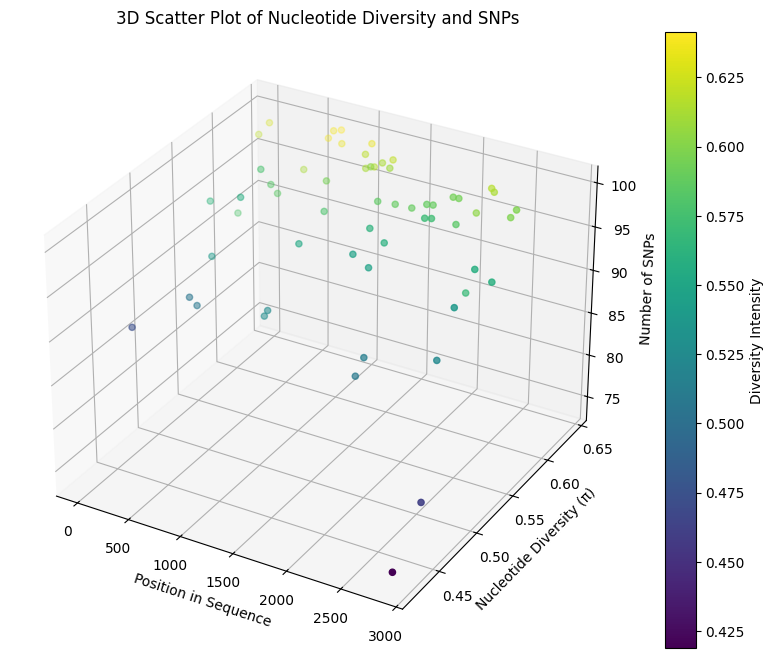

In [83]:
from Bio import AlignIO
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

alignment = AlignIO.read("aligned_sequences.aln", "fasta")
window_size = 100
step_size = 50
pi_values = []
snp_counts = []

for start in range(0, alignment.get_alignment_length() - window_size + 1, step_size):
    window = alignment[:, start:start + window_size]
    pi = 0.0
    snps = 0
    for pos in range(window_size):
        column = window[:, pos]
        bases = [b for b in column if b not in ("-", "N")]
        if len(set(bases)) > 1:
            snps += 1
        freqs = [bases.count(b) for b in set(bases)]
        total = sum(freqs)
        if total > 1:
            pi_site = 1 - sum((f / total) ** 2 for f in freqs)
            pi += pi_site
    pi_values.append(pi / window_size if window_size > 0 else 0)
    snp_counts.append(snps)

positions = np.arange(0, len(pi_values) * step_size, step_size)
lengths = [len(rec.seq) for rec in alignment]  

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(positions, pi_values, snp_counts, c=pi_values, cmap='viridis')
ax.set_xlabel("Position in Sequence")
ax.set_ylabel("Nucleotide Diversity (π)")
ax.set_zlabel("Number of SNPs")
plt.title("3D Scatter Plot of Nucleotide Diversity and SNPs")
plt.colorbar(scatter, label="Diversity Intensity")
plt.savefig("3d_nucleotide_diversity.png", dpi=300)
plt.show()

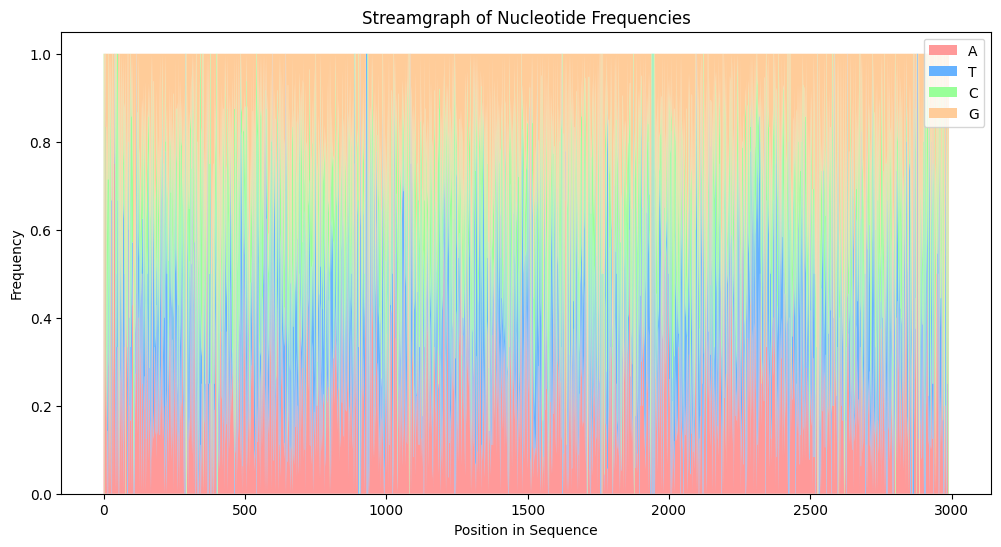

In [84]:
from Bio import AlignIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

alignment = AlignIO.read("aligned_sequences.aln", "fasta")

n_positions = alignment.get_alignment_length()
nucleotide_freqs = {base: [] for base in "ATCG"}
for pos in range(n_positions):
    column = alignment[:, pos]
    total = sum(1 for b in column if b not in ("-", "N"))
    for base in "ATCG":
        freq = column.count(base) / total if total > 0 else 0
        nucleotide_freqs[base].append(freq)

data = pd.DataFrame(nucleotide_freqs, index=range(n_positions))

plt.figure(figsize=(12, 6))
plt.stackplot(range(n_positions), data["A"], data["T"], data["C"], data["G"], 
              labels=["A", "T", "C", "G"], colors=["#FF9999", "#66B2FF", "#99FF99", "#FFCC99"])
plt.legend(loc="upper right")
plt.xlabel("Position in Sequence")
plt.ylabel("Frequency")
plt.title("Streamgraph of Nucleotide Frequencies")
plt.savefig("nucleotide_streamgraph.png", dpi=300)
plt.show()

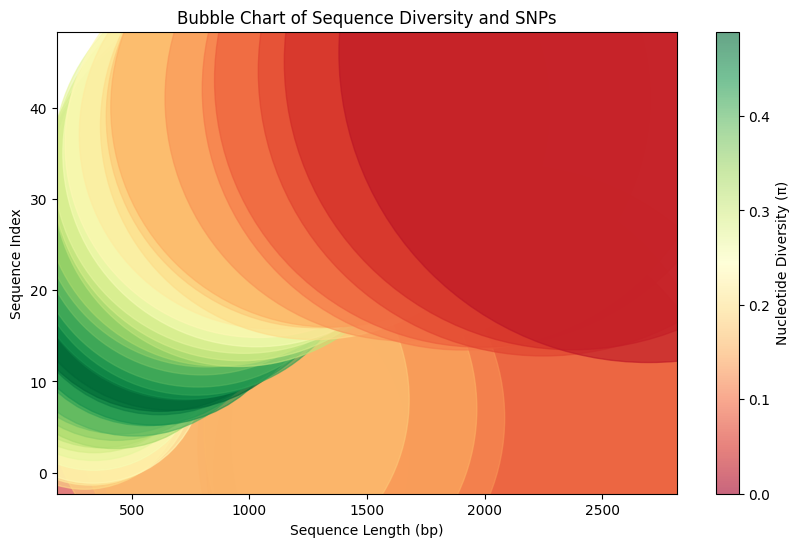

In [85]:
from Bio import SeqIO
import matplotlib.pyplot as plt

records = list(SeqIO.parse("filtered_sequences.fasta", "fasta"))
lengths = [len(rec.seq) for rec in records]
snp_counts = [sum(1 for i in range(len(rec.seq)-1) if rec.seq[i] != rec.seq[i+1]) for rec in records]  
diversity = [0.5 - abs(0.5 - i/len(lengths)) for i in range(len(lengths))] 

plt.figure(figsize=(10, 6))
plt.scatter(lengths, range(len(records)), s=[s * 100 for s in snp_counts], c=diversity, cmap="RdYlGn", alpha=0.6)
plt.colorbar(label="Nucleotide Diversity (π)")
plt.xlabel("Sequence Length (bp)")
plt.ylabel("Sequence Index")
plt.title("Bubble Chart of Sequence Diversity and SNPs")
plt.savefig("bubble_chart_diversity.png", dpi=300)
plt.show()

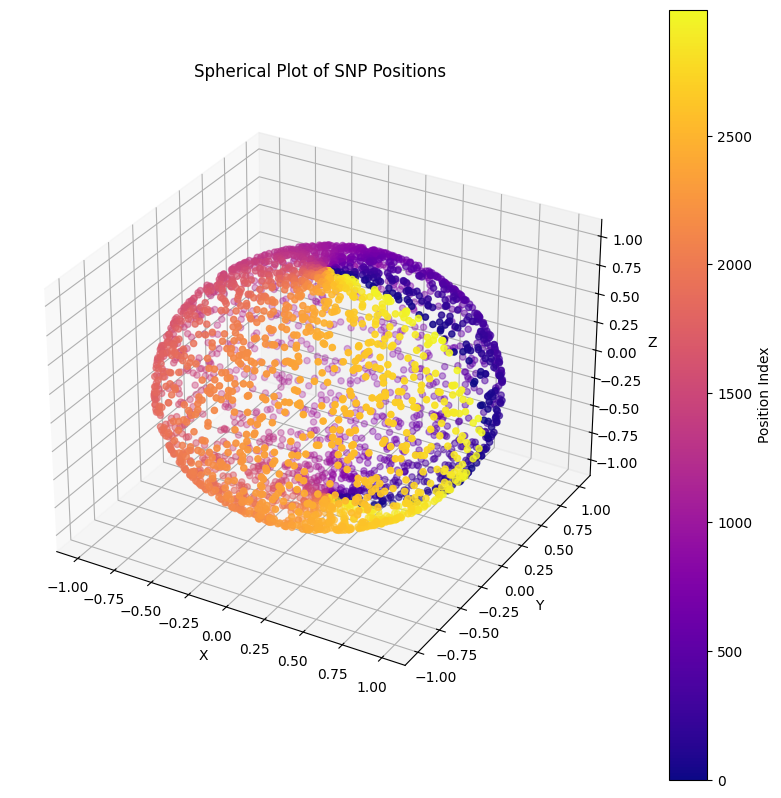

In [94]:
from Bio import AlignIO
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

alignment = AlignIO.read("aligned_sequences.aln", "fasta")

snp_positions = []
for pos in range(alignment.get_alignment_length() - 1):
    column = alignment[:, pos]
    next_column = alignment[:, pos + 1]
    if len(set(column)) > 1 or len(set(next_column)) > 1:
        snp_positions.append(pos)

theta = np.linspace(0, 2 * np.pi, len(snp_positions))
phi = np.pi * np.random.rand(len(snp_positions))
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=snp_positions, cmap='plasma')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title("Spherical Plot of SNP Positions")
plt.colorbar(scatter, label="Position Index")
plt.savefig("spherical_snp_plot.png", dpi=300)
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x0000020A42AEC400> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

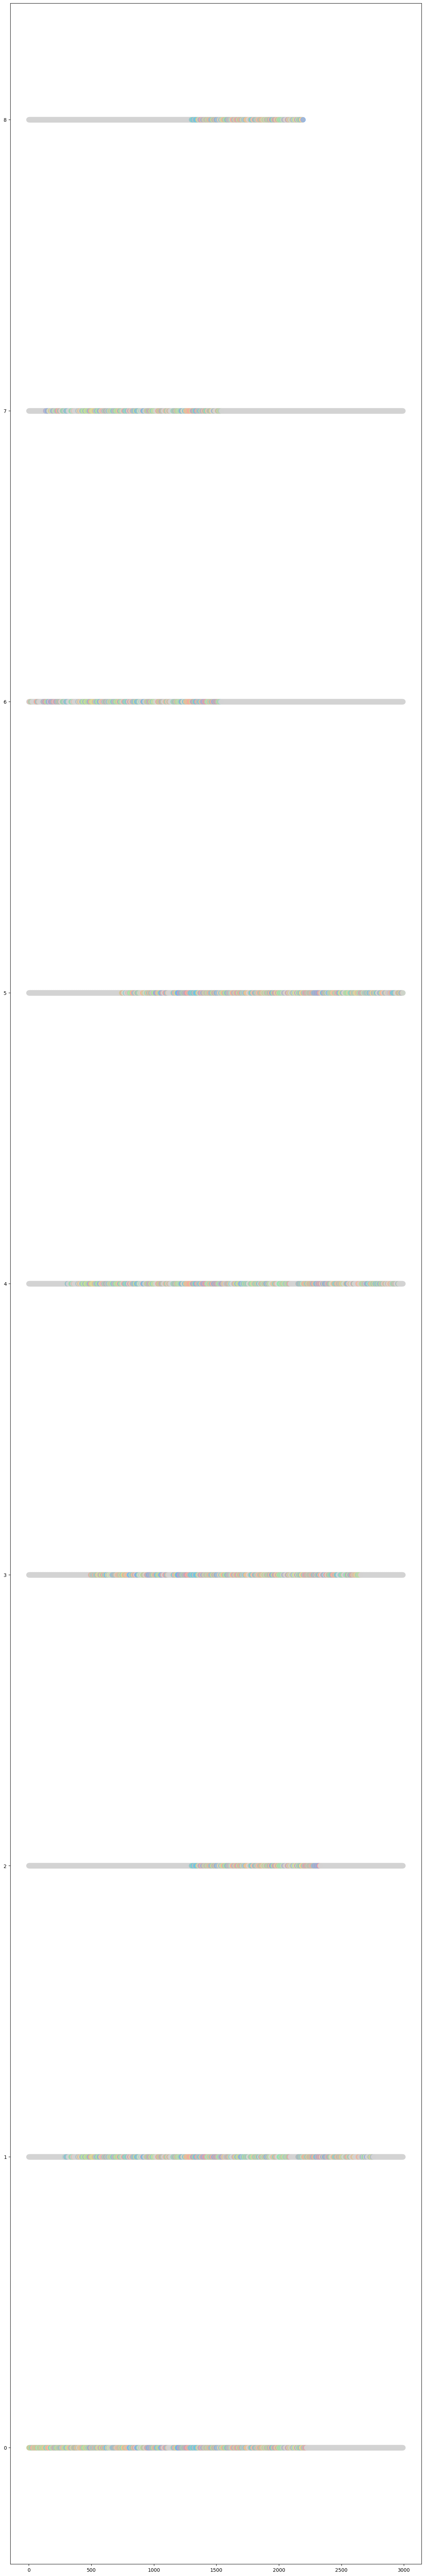

In [112]:
from Bio import AlignIO
import matplotlib.pyplot as plt
import numpy as np

alignment = AlignIO.read("aligned_sequences.aln", "fasta")

n_sequences = len(alignment)
colors = {'A': '#FF9999', 'T': '#66B2FF', 'C': '#99FF99', 'G': '#FFCC99', '-': '#D3D3D3'}

plt.figure(figsize=(15, n_sequences * 2))  
for i, record in enumerate(alignment):
    sequence = str(record.seq)
    positions = range(len(sequence))
    y_offset = i  
    for j, base in enumerate(sequence):
        plt.scatter(j, y_offset, c=colors.get(base, '#000000'), s=100, alpha=0.6)

plt.title("Gene Art Visualization of All blaTEM Sequences")
plt.xlabel("Position")
plt.ylabel("Sequence Index")
plt.yticks(range(n_sequences), [f"Seq {i+1}" for i in range(n_sequences)])  
plt.tight_layout()
plt.savefig("gene_art_all_sequences.png", dpi=300)
plt.show()

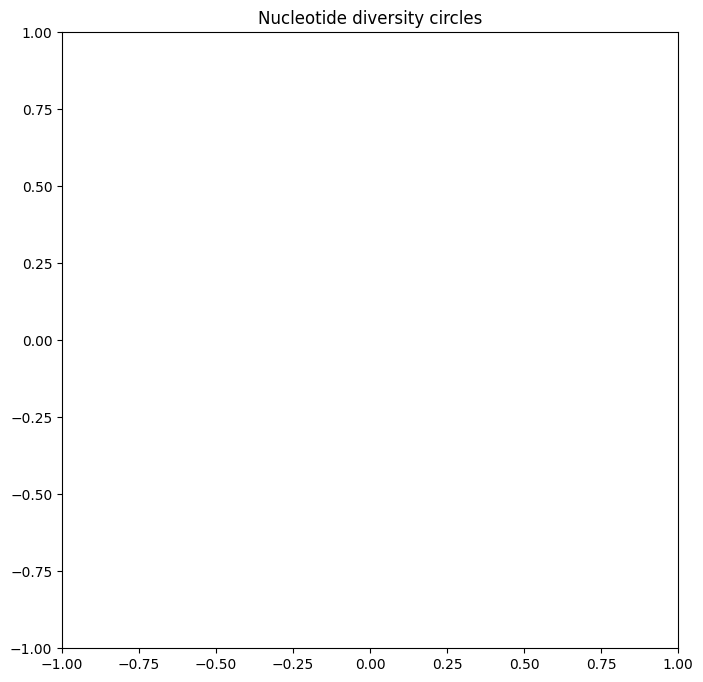

In [115]:
from Bio import AlignIO
import matplotlib.pyplot as plt

alignment = AlignIO.read("aligned_sequences.aln", "fasta")
window_size = 100
step_size = 50
pi_values = []

for start in range(0, alignment.get_alignment_length() - window_size + 1, step_size):
    window = alignment[:, start:start + window_size]
    pi = 0.0
    for pos in range(window_size):
        column = [record.seq[pos] for record in window if record.seq[pos] not in ("-", "N")]
        if len(set(column)) > 1:
            freqs = [column.count(b) for b in set(column)]
            total = sum(freqs)
            pi += 1 - sum((f / total) ** 2 for f in freqs)
    pi_values.append(pi / window_size if window_size > 0 else 0)

fig, ax = plt.subplots(figsize=(8, 8))
for i, pi in enumerate(pi_values):
    ax.add_patch(plt.Circle((0, 0), radius=pi * 10, color='b', alpha=0.5, fill=False))
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')
plt.title("Nucleotide diversity circles")
plt.savefig("concentric_circles_diversity.png", dpi=300)
plt.show()

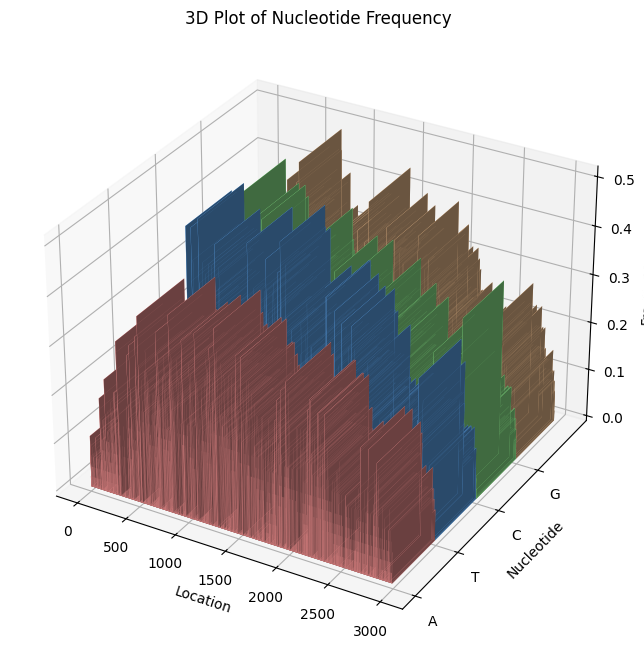

In [117]:
from Bio import AlignIO
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# قراءة المحاذاة
alignment = AlignIO.read("aligned_sequences.aln", "fasta")
n_positions = alignment.get_alignment_length()
n_sequences = len(alignment)

# حساب الترددات
freq_A = [sum(1 for record in alignment if record.seq[pos] == 'A') / n_sequences for pos in range(n_positions)]
freq_T = [sum(1 for record in alignment if record.seq[pos] == 'T') / n_sequences for pos in range(n_positions)]
freq_C = [sum(1 for record in alignment if record.seq[pos] == 'C') / n_sequences for pos in range(n_positions)]
freq_G = [sum(1 for record in alignment if record.seq[pos] == 'G') / n_sequences for pos in range(n_positions)]

# إعداد البيانات
x = np.arange(n_positions)
y = np.array([0, 1, 2, 3])  # لـ A, T, C, G
X, Y = np.meshgrid(x, y)
Z = np.array([freq_A, freq_T, freq_C, freq_G])

# رسم الأعمدة
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
for i in range(4):
    ax.bar3d(X[i], Y[i], 0, 1, 1, Z[i], color=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'][i])
    
ax.set_xlabel("Location")
ax.set_ylabel("Nucleotide")
ax.set_zlabel("Frequency")
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(['A', 'T', 'C', 'G'])
plt.title("3D Plot of Nucleotide Frequency")
plt.savefig("3d_bar_nucleotide.png", dpi=300)
plt.show()

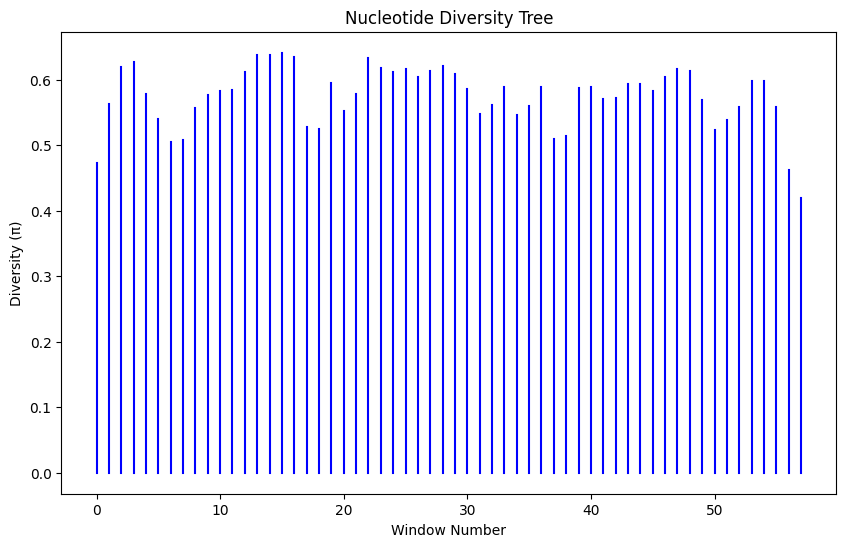

In [118]:
from Bio import AlignIO
import matplotlib.pyplot as plt

alignment = AlignIO.read("aligned_sequences.aln", "fasta")
window_size = 100
step_size = 50
pi_values = []

for start in range(0, alignment.get_alignment_length() - window_size + 1, step_size):
    window = alignment[:, start:start + window_size]
    pi = 0.0
    for pos in range(window_size):
        column = [record.seq[pos] for record in window if record.seq[pos] not in ("-", "N")]
        if len(set(column)) > 1:
            freqs = [column.count(b) for b in set(column)]
            total = sum(freqs)
            pi += 1 - sum((f / total) ** 2 for f in freqs)
    pi_values.append(pi / window_size if window_size > 0 else 0)

fig, ax = plt.subplots(figsize=(10, 6))
for i, pi in enumerate(pi_values):
    ax.plot([i, i], [0, pi], 'b-')
ax.set_title("Nucleotide Diversity Tree")
ax.set_xlabel("Window Number")
ax.set_ylabel("Diversity (π)")
plt.savefig("tree_like_diversity.png", dpi=300)
plt.show()

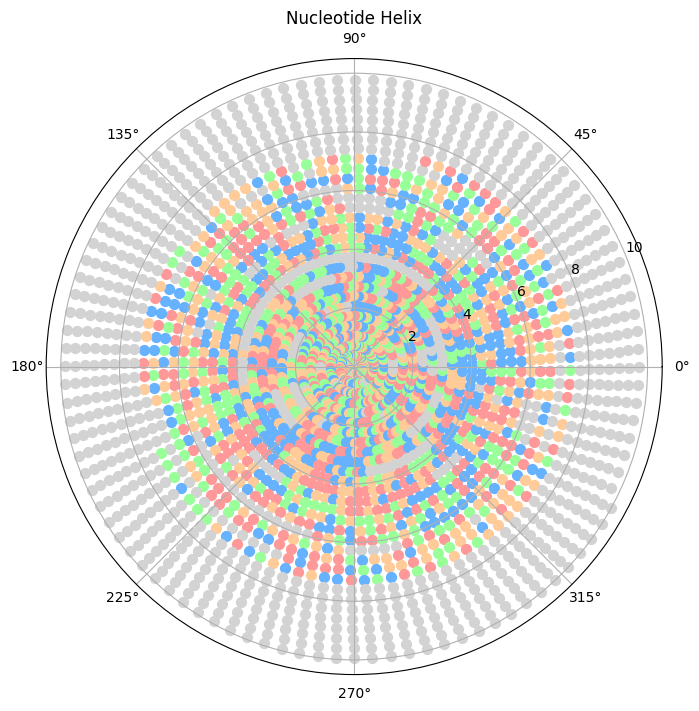

In [121]:
from Bio import AlignIO
import matplotlib.pyplot as plt
import numpy as np

alignment = AlignIO.read("aligned_sequences.aln", "fasta")
sequence = str(alignment[0].seq)  
colors = {'A': '#FF9999', 'T': '#66B2FF', 'C': '#99FF99', 'G': '#FFCC99', '-': '#D3D3D3'}

theta = np.linspace(0, 2 * np.pi * len(sequence) / 100, len(sequence))
r = np.linspace(0, 10, len(sequence))

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))
for i, base in enumerate(sequence):
    ax.scatter(theta[i], r[i], c=colors.get(base, '#000000'), s=50)
ax.set_title("Nucleotide Helix")
plt.savefig("spiral_nucleotide.png", dpi=300)
plt.show()